In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def matprint(mat, fmt="g"):
    """
    Pour une un print plus clair de la matrice
    https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75
    """
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# Table of contents
* [Algorithme non distribué 2 taches 2 classes](#Algorithme-non-distribué-2-taches-2-classes)
     * [1ère étape: Calcul des moyennes empiriques](#1ère-étape)
     * [2ème étape: Estimation de $c$ et de $\mathcal{M}$](#2ème-étape)
     * [3ème étape: Calcul des labels optimaux](#3ème-étape)
     * [4ème étape: Estimation des $m_{tj}$](#4ème-étape)
     * [5ème étape: Calcul de $V$](#5ème-étape)
     * [6ème étape: Evaluation et calcul d'erreur](#6ème-étape)
* [2-class Gaussian mixture transfer](#2-class-Gaussian-mixture-transfer-(c.f.-Figure-2))
* [Adding Tasks](#Adding-tasks)
* [Algorithme distribué 2-tâches 2-classes](#Algorithme-distribué-2-tâches-2-classes)
     * [Serveur isolé](#Serveur-isolé)
* [Distributively adding tasks](#Distributively-adding-tasks)
     * [Working with real data](#Real-Data)
* [Optimalité](#Optimalité)
* [Algorithme distribué k-tâches 2-classes](#Algorithme-distribué-k-tâches-m-classes)
     

Créons des données synthétiques gaussiennes. Ici nous nous intéresserons dans un premier temps au cas où $m=2$. (Binary MTL Supervised Principal Component Analysis) 

# Algorithme non distribué 2 taches 2 classes
Fonctions pour générer des données synthétiques gaussiennes

In [3]:
def mean_random_matrix(m, k, p, l, h, random_seed=42):
    """
    Retourne une matrice M de taille pxm*k contenant
    les moyennes de chaque composante de chaque vecteur aléatoire
    pour l'instant les moyennes sont tirées aléatoirement 
    suivant la loi uniforme sur l, h (pas convaincu par ce choix)
    m est le nombre de classes
    k est le nombre de taches
    p est le nombre de features
    """
    np.random.seed(random_seed)
    M = []
    tmp = []
    for task in range(k):
        tmp = []
        for classe in range(m):
            # on crée un vecteur de moyennes égales pour chaque classes
            # de sorte à créer des classes gravitant autour d'une meme moyenne
            tmp.append(np.ones((p,1))*np.random.uniform(low = 0.0, high = h))
        M.append(tmp)
    return M

In [4]:
def mean_matrix(p, beta=None, k=2, m=2, random_seed=42, random=False):
    """
    Crée des vecteurs de moyennes en respectant les conditions de non trivialité 
    retourne un tableau contenant k tableaux de m moyennes.
    beta est le paramètre de task relatedness. Si beta n'est pas précisé, il est tiré au hasard uniformément sur [0,1] pour chaque t.
    k=2, m=2 par défaut
    """
    np.random.seed(random_seed)
    mu = np.zeros((p,1))
    mu[0]= 1
    mu_ortho = np.zeros((p,1))
    mu_ortho[1] = 1
    
    M = []
    classes = []
    for l in range(m):
        classes.append((-1)**l*mu)
    M.append(classes)
    
    for t in range(1, k):
        if random:
            print("random")
            beta = np.random.uniform(0, 1)
            print("beta", beta)
        mu_t = beta*mu+np.sqrt(1-beta**2)*mu_ortho
        classes = []
        for l in range(m):
            classes.append((-1)**l*mu_t)
        M.append(classes)
    return M

In [5]:
def gaussian_synthetic_data(n, p, m, t, n_t, M, random_seed=42):
    """
    Renvoie un tableau de données synthétiques gaussiennes. X[0] accède aux données de la premiere tache.
    X[0][1] accede aux données de la deuxieme classe de la premiere tache.
    (vecteurs gaussiens de taille n_j * p tq sum(n_j for j) = n)
    à partir du nombre d'échantillons n de taille p et du nombre de classe m.
    t est le nombre de tâches
    n_t est un vecteur comprenant les différentes valeurs n_j pour chaque task
    M est la matrice des moyennes de chaque composante 
    de chaque vecteur aléatoire
    """
    # assert(sum(n_j)/n==1
    
    np.random.seed(random_seed)
    X = []
    tmp = []
    y_test = []
    for task in range(t):
        # pour une tache on a m classes
        tmp = []
        for k in range(m):
            X_k = np.empty((n_t[task][k], p))
            # on prendra la transposée a la fin
#             print( n_t[task][k])
            for j in range(n_t[task][k]):
                # on crée n_j[task][k] vecteurs aléatoires de taille 1xp
                # std = 1?
                # comment utiliser des vecteurs de moyennes pour générer les données ?
                mean = np.reshape(M[task][k], p)
                X_k[j] = np.random.multivariate_normal(mean, np.identity(p))
                y_test.append(k)
            X_k = np.transpose(X_k)
            #print(k)
            tmp.append(X_k)
            # print("tmp = ", tmp)
        X.append(tmp)
            
    return X, y_test

## 1ère étape
Calcul des moyennes empiriques, et calcul de la matrice $M\in\mathbb{R}^{p\times 2k}$
$$\frac{1}{n_{tj}}X_{tj}\mathbb{1}_{n_{tj}}=\frac{1}{n_{tj}}\sum_{l=1}^{n_{tj}}x_{tl}^{(j)}$$

In [6]:
def empirical_mean(nb_tasks, nb_classes, X, p, n_t, display=False):
    """
    Retourne la matrice M avec les produits scalaires croisés
    cf. Remark 1
    """
    
    M = np.empty((nb_tasks*nb_classes, nb_tasks*nb_classes)) # ici 4x4
    for i in range(nb_tasks):
        for j in range(nb_classes):
            for k in range(nb_tasks):
                for l in range(nb_classes):
                    if i == k and j == l:
                        moitie = int(n_t[i][j]/2)
#                         print("DEBUG diagonal")
#                         print(f"i = {i}, j = {j}")
#                         print(i*nb_classes+j, i*nb_classes+j)
#                         print("moitie : ", moitie)
                        
                        M[i*nb_classes+j][i*nb_classes+j] = np.ones((moitie, 1)).T@X[i][j].T[:moitie]@X[i][j].T[moitie:].T@np.ones((moitie))
                        M[i*nb_classes+j][i*nb_classes+j] /= moitie**2
                    else:
#                         print(i*nb_classes+j, k*nb_classes+l)
#                         print(i, j, k, l)
                        M[i*nb_classes+j][k*nb_classes+l] = np.ones((n_t[i][j], 1)).T@X[i][j].T@X[k][l]@np.ones((n_t[k][l]))
                        M[i*nb_classes+j][k*nb_classes+l] /= n_t[i][j]*n_t[k][l]
    
    if display:
        for t in range(nb_tasks):
            for l in range(nb_classes):
                print(f"class {t*nb_classes+l} empirical mean = {np.mean(M[t*nb_classes+l])}")
                
    return M

In [7]:
def true_mean(M, p, nb_tasks, nb_classes):
    """
    Retourne un ndarray contenant les vraies moyennes avec lequel on peut travailler
    """
    true_M = np.empty((nb_tasks*nb_classes, p))
    for t in range(nb_tasks):
        for l in range(nb_classes):
            mean = np.reshape(M[t][l], (p,))
            true_M[t*nb_classes+l] = mean

    return np.transpose(true_M)

In [8]:
# utile pour les puissances négatives
def power_diagonal_matrix(D, exponent):
    diag = np.zeros(len(D))
    for i in range(len(D)):
        diag[i] = D[i][i]**exponent
    
    return np.diag(diag)

## 2ème étape
Estimer $c$ et $\mathcal{M}\in\mathbb{R}^{2k\times 2k}$. 
$c=\left[ c_{11},\ldots,c_{km} \right]^T\in\mathbb{R}^{km}$

In [9]:
def estimate_c(n_t, n, nb_tasks, nb_classes):
    """
    Estime le vecteur c en divisant n_t[nb_tasks][nb_classes]/n
    """
    c = np.empty(nb_tasks*nb_classes)
    for task in range(nb_tasks):
        for m in range(nb_classes):
            c[task*nb_classes+m]=n_t[task][m]/n
            
    return c

In [10]:
def compute_M_cal(n,p,Dc,MM, k=2, display=False):
    """
    renvoie la matrice M cursive estimée.
    O(2*k)
    """
    c0 = k*p/n
    correlation_matrix = 1/c0*np.power(Dc, 1/2)@MM@np.power(Dc, 1/2)
    if display==True:
        plt.imshow(correlation_matrix)
        plt.show()
    return correlation_matrix

## 3ème étape
Let's compute optimal labels

In [11]:
# a revoir ?

def label_evaluation(nb_tasks, nb_classes, Dc, M_estimated, c0, task_target=None):
    """
    Evalue le label y pour une tache t pour 2 classes
    task_target=None par défaut, permet de choisir la tâche target en cas d'algo distribué.
    """
    inverse = np.linalg.inv(M_estimated+np.identity(nb_classes*nb_tasks))
    # 0(16*k^3)
    power_dc = power_diagonal_matrix(Dc, -1/2)
    # O(2*k)
    y = np.zeros((nb_tasks*nb_classes, 1))
    e3_e4 = np.zeros((nb_tasks*nb_classes,1))
    if task_target is not None:
        e3_e4[2*task_target] = 1
        e3_e4[2*task_target+1] = -1
    else:
        e3_e4[-2] = 1
        e3_e4[-1] = -1
    tilde_y=np.linalg.solve((Dc+Dc@M_estimated@Dc*1/c0),(Dc*1/c0@M_estimated@(e3_e4)))
    # O(8*k^3)
    return tilde_y
#malik's formula:
#tilde_y=(diag(c)*MM*diag(c)/co+diag(c))\((e3-e4)'*MM*diag(c))';

## 4ème étape
Estimation des $m_{tj}$, étant les $k\times m$ moyennes estimées pour modéliser nos données.

In [12]:
def asymptotic_mean(nb_tasks, nb_classes, y_tilde, Dc, correlation_matrix, t, j):
    """
    compute asymptotic mean m_tj
    t current task
    j current class
    """
    y_transpose = np.transpose(y_tilde)
    etj = np.zeros((nb_tasks*nb_classes, 1))
    etj[t*nb_classes+j] = 1
    power_dc = power_diagonal_matrix(Dc, -1/2)
    # Dc^1/2 ou Dc^{-1/2} ?
    m_tj = y_transpose.dot(np.power(Dc, 1/2)).dot(correlation_matrix).dot(power_dc).dot(etj)
    m_tj /= np.sqrt(y_transpose.dot(np.power(Dc, 1/2).dot(correlation_matrix).dot(np.power(Dc, 1/2)) + Dc).dot(y_tilde))
    return m_tj[0][0]

## 5ème étape
Calcul de $V$ le sous-espace engendrés par les $\tau$ plus grands vecteurs propres. Dans le cas du binary MTL-SPCA, $V=\frac{Xy}{\lVert Xy \rVert}=\frac{XJ\tilde{y}}{\lVert XJ\tilde{y} \rVert}\in\mathbb{R}^{p\times1}$, avec $J\in\mathbb{R}^{n\times km}$

In [13]:
def aggregate_array(X, p, n, nb_tasks, nb_classes):
    X_aggregated = np.empty((p, n))
    class_1 = X[0][0]
    for t in range(nb_tasks):
        for l in range(nb_classes):
            if t==0 and l==0:
                continue
            class_1 = np.append(class_1, X[t][l], 1)
    X_aggregated = class_1
    return X_aggregated

$V=\frac{Xy}{\lVert Xy \rVert}=\frac{XJ\tilde{y}}{\lVert XJ\tilde{y} \rVert}$

In [14]:
def create_J(nb_classes, nb_tasks, n, n_t):
    # enlever paramètre n
    left = 0
    beg = 0
    for i in range(nb_tasks):
        left += int(sum(n_t[i]))
    J = np.zeros((left, nb_tasks*nb_classes))
    #matprint(J)
    for t in range(nb_tasks):
        for j in range(nb_classes):
            for i in range(beg, beg+n_t[t][j]):
                J[i][t*nb_classes+j] = 1
            beg += n_t[t][j]
    return J

In [15]:
def compute_V_old(y_tilde, X, J):
    """
    Utilise la formule explicite de V pour la classification binaire
    """
    xy_product = X.dot(J).dot(y_tilde)
    return xy_product/np.linalg.norm(xy_product)

def compute_V(y, X, J, n):
    """
    Recalcule V (calcul vecteur propre)
    Vstar dans le fichier matlab
    Division par p, si les X pas normalisé ?
    wtf is wrong with V? 
    """
    #X*J*(tilde_y*tilde_y')*J'*X'/n
    #print(X.shape)
    eigenvalue, V = np.linalg.eig(X.dot(J).dot((y).dot(y.T)).dot(J.T).dot(X.T)/(n))
    maximum = eigenvalue[0]
    idx_larg = 0
    # retrieve the index of the largest eigenvalue
    for idx, value in enumerate(eigenvalue):
        if value > maximum:
            maximum = value
            idx_larg = idx
    
    largest_eigenvalue = np.sort(eigenvalue.real)[-1]
    return V.T[idx_larg].real

## 6ème étape
Evaluation de nouvelles données $\mathbf{x}$ : 
$V^T\mathbf{x}$

On utilise les données du test set $X\_test$. On obtient de très mauvais résultats

In [16]:
def create_mt(t, m, y, Dc, correlation_matrix):
    m_t = []
    for k in range(t):
        m_tj = []
        for l in range(m):
            m_tj.append(asymptotic_mean(t, m, y, Dc, correlation_matrix, k, l))
        m_t.append(m_tj)

    return m_t

In [17]:
def compute_score(V, x, m_t):
    """
    x vecteur aléatoire que l'on veut classifier
    On compare V^Tx à la moyenne des moyennes estimées pour les deux classes de la tache t
    """
    x_projection = np.transpose(V).dot(x)
    average_mean = 1/2*(m_t[0] + m_t[1])
    return (1 if x_projection > 0 else -1) 

In [18]:
from scipy import special as sp
def qfunc(x):
    return 0.5-0.5*sp.erf(x/np.sqrt(2))

In [19]:
def error_rate(nb_tasks, nb_classes, Dc, M_cur, c0, task_target=1):
    e3 = np.zeros((nb_tasks*nb_classes, 1))
    e3[2*task_target] = 1
    power_dc = power_diagonal_matrix(Dc, -1/2)
    inv = np.linalg.inv(M_cur+np.identity(nb_tasks*nb_classes))
    print("arg q-func : ")
    print(e3.T.dot(M_cur).dot(Dc).dot(np.linalg.inv(Dc.dot(M_cur).dot(Dc)+c0*Dc)).dot(Dc).dot(M_cur).dot(e3))
    return qfunc(np.sqrt(e3.T.dot(M_cur).dot(Dc).dot(np.linalg.inv(Dc.dot(M_cur).dot(Dc)+c0*Dc)).dot(Dc).dot(M_cur).dot(e3)))
    #return qfunc(1/2*np.sqrt(et_trans.dot(power_dc).dot(M_cur).dot(inv).dot(M_cur).dot(power_dc).dot(et1_et2)))
#erfc(sqrt(e3'*MM*diag(c)*inv((diag(c)*MM*diag(c)+diag(co*c/k)))*diag(c)*MM*e3)/(sqrt(2)))/2;

In [20]:
def plot_error_rate(nb_tasks, nb_classes, emp_rate, error_rate, m_t, Dc, M_cur):
    plt.scatter(1, emp_rate, label="empirical error")
    plt.scatter(1, [error_rate(m_t[1], nb_tasks, nb_classes, Dc, M_cur)], label="theoritical error")
    plt.grid()
    plt.ylim((0,1))
    plt.xlim((-0.5, 0.5))
    plt.legend()
    plt.title(f"Classification error rate per task")
    plt.show()

In [21]:
def compute_error_rate(X_test, V, m_t, nb_tasks, nb_classes, n_t, Dc, c0, task_target=1):
    """
    Compute and plot classification error rate on test set
    """
#     print("mt1= \n", m_t[1])
    emp_rate = []
    error = 0
    ni = 0
    error = 0
    for t in range(nb_tasks):
        
        ni += sum(n_t[t])
        for l in range(nb_classes):
            for i in range(n_t[t][l]):
                # on prend la transposée pour pouvoir travailler avec les colonnes
                score = compute_score(V, X_test[t][l].T[i], m_t[task_target])
                if (score == 1 and l == 1):
                    error +=1
                elif (score == -1 and l == 0):
                    error +=1
        
    erreur_emp = error/ni

    if erreur_emp > 0.5:
        erreur_emp=1-erreur_emp
    emp_rate.append(erreur_emp)
    return np.mean(emp_rate)

In [22]:
def debug_histogram(V, X_test, n_t):
    """
    Trace l'histogramme de V^T*x_1 et V^T*x_2.
    """
#     print(X1[0][0])
#     print(n_t[0][0])
    alpha = 0.5
    bins = 20
    plt.hist(V.T.dot(X_test.T[:n_t[0][0]].T), bins = bins, alpha=alpha, label=r"$C_1$")
    plt.hist(V.T.dot(X_test.T[n_t[0][0]:].T), bins = bins, alpha=alpha, label=r"$C_2$")
    plt.title(r"Histogramme des données de tests projetées sur $V$ : $V^Tx_j$")
    plt.legend()
    plt.show()

# 2-class Gaussian mixture transfer (c.f. Figure 2)

In [23]:
from time import time
plt.style.use('seaborn-dark-palette')

MM : 

   1.02528  -0.991361  -0.094621  -0.0359668  
 -0.991361   0.984622   0.187808   0.0939279  
 -0.094621   0.187808    1.10094   -0.842466  
-0.0359668  0.0939279  -0.842466    0.804304  
c : 
[0.47619048 0.47619048 0.02380952 0.02380952]


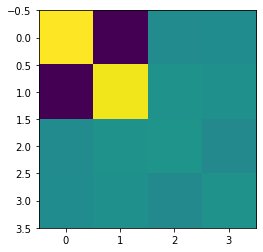

   5.12642  -4.95681   -0.10579  -0.0402121  
  -4.95681   4.92311   0.209975    0.105015  
  -0.10579  0.209975   0.275235   -0.210616  
-0.0402121  0.105015  -0.210616    0.201076  
MM True = 
[[ 1. -1.  0.  0.]
 [-1.  1.  0.  0.]
 [ 0.  0.  1. -1.]
 [ 0.  0. -1.  1.]]
 5  -5      0      0  
-5   5      0      0  
 0   0   0.25  -0.25  
 0   0  -0.25   0.25  
c0 :  0.047619047619047616
y = 
0.0971069  
 0.166729  
  21.1841  
 -18.3863  
y true = 
  0  
  0  
 21  
-21  
arg q-func : 
[[0.5]]
[0.21099999999999997] [0.23975006109347674]
MM : 

  1.02528  -0.991361  0.0164554  -0.147043  
-0.991361   0.984622  0.0767187   0.205017  
0.0164554  0.0767187     1.0653   -0.83449  
-0.147043   0.205017   -0.83449   0.823992  
c : 
[0.47619048 0.47619048 0.02380952 0.02380952]


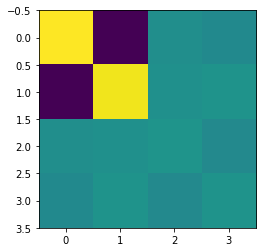

  5.12642   -4.95681  0.0183977  -0.164399  
 -4.95681    4.92311  0.0857741   0.229216  
0.0183977  0.0857741   0.266325  -0.208622  
-0.164399   0.229216  -0.208622   0.205998  
MM True = 
[[ 1.         -1.          0.11111111 -0.11111111]
 [-1.          1.         -0.11111111  0.11111111]
 [ 0.11111111 -0.11111111  1.         -1.        ]
 [-0.11111111  0.11111111 -1.          1.        ]]
        5         -5   0.124226  -0.124226  
       -5          5  -0.124226   0.124226  
 0.124226  -0.124226       0.25      -0.25  
-0.124226   0.124226      -0.25       0.25  
c0 :  0.047619047619047616
y = 
 0.196318  
0.0296185  
   21.014  
 -18.2948  
y true = 
 0.111768  
-0.111768  
  20.8758  
 -20.8758  
arg q-func : 
[[0.50295683]]
[0.21099999999999997, 0.20899999999999996] [0.23975006109347674, 0.23910189492427802]
MM : 

  1.02528   -0.991361    0.127203  -0.257791  
-0.991361    0.984622  -0.0345655   0.316301  
 0.127203  -0.0345655     1.02986  -0.825862  
-0.257791    0.316301  

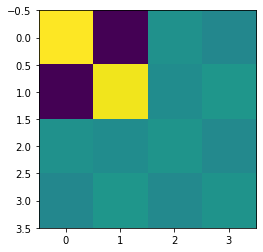

  5.12642    -4.95681    0.142218  -0.288219  
 -4.95681     4.92311  -0.0386454   0.353635  
 0.142218  -0.0386454    0.257466  -0.206466  
-0.288219    0.353635   -0.206466   0.210544  
MM True = 
[[ 1.         -1.          0.22222222 -0.22222222]
 [-1.          1.         -0.22222222  0.22222222]
 [ 0.22222222 -0.22222222  1.         -1.        ]
 [-0.22222222  0.22222222 -1.          1.        ]]
        5         -5   0.248452  -0.248452  
       -5          5  -0.248452   0.248452  
 0.248452  -0.248452       0.25      -0.25  
-0.248452   0.248452      -0.25       0.25  
c0 :  0.047619047619047616
y = 
 0.294944  
-0.116306  
  20.5773  
 -17.8761  
y true = 
 0.227574  
-0.227574  
  20.4943  
 -20.4943  
arg q-func : 
[[0.51204094]]
[0.21099999999999997, 0.20899999999999996, 0.207] [0.23975006109347674, 0.23910189492427802, 0.23712834068265354]
MM : 

  1.02528  -0.991361   0.237603  -0.368191  
-0.991361   0.984622  -0.146057   0.427792  
 0.237603  -0.146057   0.994642  -0.81

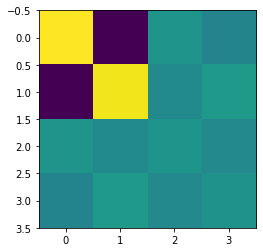

 5.12642   -4.95681   0.265648   -0.41165  
-4.95681    4.92311  -0.163296   0.478286  
0.265648  -0.163296   0.248661  -0.204136  
-0.41165   0.478286  -0.204136    0.21469  
MM True = 
[[ 1.         -1.          0.33333333 -0.33333333]
 [-1.          1.         -0.33333333  0.33333333]
 [ 0.33333333 -0.33333333  1.         -1.        ]
 [-0.33333333  0.33333333 -1.          1.        ]]
        5         -5   0.372678  -0.372678  
       -5          5  -0.372678   0.372678  
 0.372678  -0.372678       0.25      -0.25  
-0.372678   0.372678      -0.25       0.25  
c0 :  0.047619047619047616
y = 
 0.396624  
-0.277872  
  19.8409  
 -17.0926  
y true = 
 0.351955  
-0.351955  
  19.8268  
 -19.8268  
arg q-func : 
[[0.52793296]]
[0.21099999999999997, 0.20899999999999996, 0.207, 0.2055] [0.23975006109347674, 0.23910189492427802, 0.23712834068265354, 0.23373859215337528]
MM : 

  1.02528  -0.991361   0.347616  -0.478204  
-0.991361   0.984622  -0.257777   0.539513  
 0.347616  -0.257777 

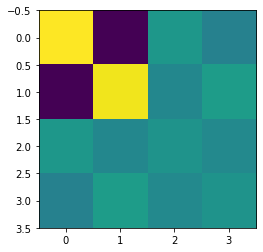

  5.12642   -4.95681   0.388647  -0.534649  
 -4.95681    4.92311  -0.288204   0.603194  
 0.388647  -0.288204   0.239915  -0.201615  
-0.534649   0.603194  -0.201615   0.218394  
MM True = 
[[ 1.         -1.          0.44444444 -0.44444444]
 [-1.          1.         -0.44444444  0.44444444]
 [ 0.44444444 -0.44444444  1.         -1.        ]
 [-0.44444444  0.44444444 -1.          1.        ]]
        5         -5   0.496904  -0.496904  
       -5          5  -0.496904   0.496904  
 0.496904  -0.496904       0.25      -0.25  
-0.496904   0.496904      -0.25       0.25  
c0 :  0.047619047619047616
y = 
 0.505349  
-0.464367  
  18.7425  
 -15.8696  
y true = 
 0.490591  
-0.490591  
  18.8196  
 -18.8196  
arg q-func : 
[[0.55191434]]
[0.21099999999999997, 0.20899999999999996, 0.207, 0.2055, 0.21150000000000002] [0.23975006109347674, 0.23910189492427802, 0.23712834068265354, 0.23373859215337528, 0.2287682743173643]
MM : 

  1.02528  -0.991361   0.457179  -0.587767  
-0.991361   0.984622 

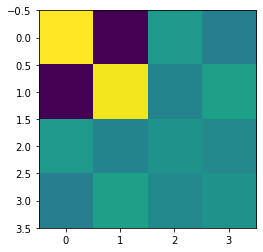

  5.12642   -4.95681   0.511141  -0.657143  
 -4.95681    4.92311  -0.413411   0.728401  
 0.511141  -0.413411   0.231239  -0.198871  
-0.657143   0.728401  -0.198871    0.22158  
MM True = 
[[ 1.         -1.          0.55555556 -0.55555556]
 [-1.          1.         -0.55555556  0.55555556]
 [ 0.55555556 -0.55555556  1.         -1.        ]
 [-0.55555556  0.55555556 -1.          1.        ]]
       5        -5   0.62113  -0.62113  
      -5         5  -0.62113   0.62113  
 0.62113  -0.62113      0.25     -0.25  
-0.62113   0.62113     -0.25      0.25  
c0 :  0.047619047619047616
y = 
 0.625969  
-0.689665  
  17.1754  
 -14.0761  
y true = 
 0.651275  
-0.651275  
  17.3818  
 -17.3818  
arg q-func : 
[[0.58614748]]
[0.21099999999999997, 0.20899999999999996, 0.207, 0.2055, 0.21150000000000002, 0.20650000000000002] [0.23975006109347674, 0.23910189492427802, 0.23712834068265354, 0.23373859215337528, 0.2287682743173643, 0.22195637062121154]
MM : 

  1.02528  -0.991361   0.566173  -0.6967

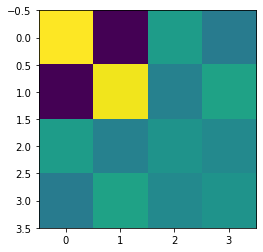

  5.12642   -4.95681   0.633001  -0.779003  
 -4.95681    4.92311  -0.538995   0.853985  
 0.633001  -0.538995   0.222651  -0.195845  
-0.779003   0.853985  -0.195845   0.224117  
MM True = 
[[ 1.         -1.          0.66666667 -0.66666667]
 [-1.          1.         -0.66666667  0.66666667]
 [ 0.66666667 -0.66666667  1.         -1.        ]
 [-0.66666667  0.66666667 -1.          1.        ]]
        5         -5   0.745356  -0.745356  
       -5          5  -0.745356   0.745356  
 0.745356  -0.745356       0.25      -0.25  
-0.745356   0.745356      -0.25       0.25  
c0 :  0.047619047619047616
y = 
 0.764805  
-0.976494  
  14.9575  
 -11.4833  
y true = 
 0.845638  
-0.845638  
  15.3624  
 -15.3624  
arg q-func : 
[[0.63422819]]
[0.21099999999999997, 0.20899999999999996, 0.207, 0.2055, 0.21150000000000002, 0.20650000000000002, 0.19999999999999996] [0.23975006109347674, 0.23910189492427802, 0.23712834068265354, 0.23373859215337528, 0.2287682743173643, 0.22195637062121154, 0.21290430

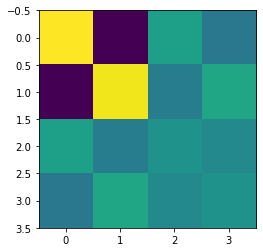

  5.12642   -4.95681   0.753967  -0.899969  
 -4.95681    4.92311  -0.665111   0.980101  
 0.753967  -0.665111   0.214187  -0.192423  
-0.899969   0.980101  -0.192423   0.225737  
MM True = 
[[ 1.         -1.          0.77777778 -0.77777778]
 [-1.          1.         -0.77777778  0.77777778]
 [ 0.77777778 -0.77777778  1.         -1.        ]
 [-0.77777778  0.77777778 -1.          1.        ]]
        5         -5   0.869582  -0.869582  
       -5          5  -0.869582   0.869582  
 0.869582  -0.869582       0.25      -0.25  
-0.869582   0.869582      -0.25       0.25  
c0 :  0.047619047619047616
y = 
0.930101  
-1.36641  
 11.7633  
-7.67019  
y true = 
 1.09249  
-1.09249  
 12.5029  
-12.5029  
arg q-func : 
[[0.70231214]]
[0.21099999999999997, 0.20899999999999996, 0.207, 0.2055, 0.21150000000000002, 0.20650000000000002, 0.19999999999999996, 0.1875] [0.23975006109347674, 0.23910189492427802, 0.23712834068265354, 0.23373859215337528, 0.2287682743173643, 0.22195637062121154, 0.21290430

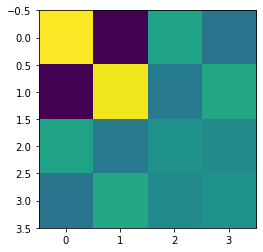

 5.12642   -4.95681   0.873373   -1.01937  
-4.95681    4.92311  -0.792154    1.10714  
0.873373  -0.792154   0.205939  -0.188309  
-1.01937    1.10714  -0.188309   0.225757  
MM True = 
[[ 1.         -1.          0.88888889 -0.88888889]
 [-1.          1.         -0.88888889  0.88888889]
 [ 0.88888889 -0.88888889  1.         -1.        ]
 [-0.88888889  0.88888889 -1.          1.        ]]
        5         -5   0.993808  -0.993808  
       -5          5  -0.993808   0.993808  
 0.993808  -0.993808       0.25      -0.25  
-0.993808   0.993808      -0.25       0.25  
c0 :  0.047619047619047616
y = 
1.12884  
-1.9495  
6.95573  
-1.7668  
y true = 
 1.42507  
-1.42507  
  8.3327  
 -8.3327  
arg q-func : 
[[0.80160226]]
[0.21099999999999997, 0.20899999999999996, 0.207, 0.2055, 0.21150000000000002, 0.20650000000000002, 0.19999999999999996, 0.1875, 0.17700000000000005] [0.23975006109347674, 0.23910189492427802, 0.23712834068265354, 0.23373859215337528, 0.2287682743173643, 0.2219563706212115

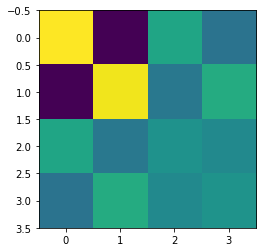

 5.12642   -4.95681   0.984401   -1.1304  
-4.95681    4.92311  -0.924176   1.23917  
0.984401  -0.924176   0.198851  -0.18048  
 -1.1304    1.23917   -0.18048  0.217189  
MM True = 
[[ 1. -1.  1. -1.]
 [-1.  1. -1.  1.]
 [ 1. -1.  1. -1.]
 [-1.  1. -1.  1.]]
       5        -5   1.11803  -1.11803  
      -5         5  -1.11803   1.11803  
 1.11803  -1.11803      0.25     -0.25  
-1.11803   1.11803     -0.25      0.25  
c0 :  0.047619047619047616
y = 
 1.20519  
-3.16697  
-1.09627  
 9.40221  
y true = 
 1.90909  
-1.90909  
 1.90909  
-1.90909  
arg q-func : 
[[0.95454545]]
[0.21099999999999997, 0.20899999999999996, 0.207, 0.2055, 0.21150000000000002, 0.20650000000000002, 0.19999999999999996, 0.1875, 0.17700000000000005, 0.16049999999999998] [0.23975006109347674, 0.23910189492427802, 0.23712834068265354, 0.23373859215337528, 0.2287682743173643, 0.22195637062121154, 0.2129043075952785, 0.20100393554334806, 0.18530737544421827, 0.16428249171959852]
Erreur relative moyenne pour n=4200 e

In [36]:
# %%prun -s cumulative
# profiling
%matplotlib inline
p = 200
m = 2
t = 2
beta = np.linspace(0,1,10)
n_t = [[2000, 2000], [100, 100]]
n = sum(list(map(sum, (n_t[i] for i in range(t)))))
n_t_test = [[1000, 1000]]
nt = sum(n_t_test[0])
# la liste temps comprendra le temps pour le training, le calcul de M et y et le temps d'inférence
emp_rate, th_rate, var, relative_error_rate = [], [], [], []

temps_MM = []
temps_estim = []
temps_inference = []
random_state = 100
R1, R2 = [], []
for b in beta:
    # on crée les données synthétiques
    M = mean_matrix(p, b, t, random_seed=random_state)
    
    X, y_bs = gaussian_synthetic_data(n, p, m, t, n_t, M, random_state)
    X_test, y_test = gaussian_synthetic_data(nt, p, m, 1, n_t_test, [M[1]], random_state)
#     M1 = empirical_mean_old(2, 2, X, p, n_t)[0]
#     MM_test = M1.T@M1
#     matprint(MM)
    
    #     X = normalisation(X, p, True)
    X_test = normalisation(X_test, p, False)
    # pas besoin de z-normalisataion puisque la moyenne des données est nulle et l'écart type est 1
    # on divise seulement par sqrt(p) parce que c'est cool 

# DEBUG
    #MM1, diag1 = empirical_mean_old(1, m, X, p, [n_t[0]])
    # On calcule les moyennes empiriques
    
    t0 = time()
    MM = empirical_mean(t, m, X, p, n_t)
    print("MM : \n")
    temps_MM.append(time() - t0)
    matprint(MM)
    # On time le calcul de MTM
    
#     r1, r2 = bayes_optimal(n_t, MM_test, p)
#     R1.append((r1+r2)/2)
#     R2.append(r2)

    t0 = time()
    c = estimate_c(n_t, n, t, m)
    print("c : ")
    print(c)
    c0 = p/n
    Dc = np.diag(c)
    correlation_matrix = compute_M_cal(n, p, Dc, MM, display=True)
    matprint(correlation_matrix)
    y = label_evaluation(t,m,Dc,MM, c0)
    temps_estim.append(time() - t0)
    # On time l'estimation de y, M, et c
    
    M_true = true_mean(M, p, t, m)
    MM_true = M_true.T@M_true
    print("MM True = ")
    print(MM_true)
    correlation_matrix_true = compute_M_cal(n, p, Dc, MM_true, display=False)
    matprint(correlation_matrix_true)
    print("c0 : ", c0)
    y_true = label_evaluation(t,m,Dc,MM_true, c0)
    print("y = ")
    matprint(y)
    print("y true = ")
    matprint(y_true)
    
    X_train_aggregated = aggregate_array(X, p, n, t, m)
    X_test_aggregated = aggregate_array(X_test, p, nt, 1, m)
    
    
    t0 = time()
    J = create_J(m, t, n, n_t)
    V = compute_V(y, X_train_aggregated, J, n)
    
#     debug_histogram(V_true, X_test_aggregated, n_t_test)
#     print("V = ")
    # pour l'instant pas vraiment utilisé
    m_t = create_mt(t, m, y, Dc, correlation_matrix)
    erreur_empirique = compute_error_rate(X_test, V, m_t, 1, m, n_t_test, Dc, c0)
    temps_inference.append(time() - t0)
    
    V_true = compute_V(y_true, X_train_aggregated, J, n)
    VTX = V.T@X_test_aggregated
    var.append(np.var(VTX))
    m_t_true = create_mt(t, m, y_true, Dc, correlation_matrix_true)
    erreur_theorique = error_rate(t, m,  Dc, MM_true, c0)[0][0]
    emp_rate.append(erreur_empirique)
    th_rate.append(erreur_theorique)
    relative_error_rate.append(abs(erreur_empirique - erreur_theorique)/erreur_theorique)
    
    print(emp_rate, th_rate)
    
erreur_relative_moy = np.mean(relative_error_rate)
print(f"Erreur relative moyenne pour n={n} et p={p}, moyennée sur 10 simulations")
print(erreur_relative_moy)

print(f"Temps moyen pour (resp.) le calcul des produits scalaires entre moyennes empiriques, l'estimation de M cursive, c et les labels optimaux y, et l'inférence : {np.mean(temps_MM)}, {np.mean(temps_estim)}, {np.mean(temps_inference)}")

print(f"Temps total moyen : {round(np.mean(temps_MM)+np.mean(temps_estim)+np.mean(temps_inference), 3)} s")
%matplotlib qt
lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.plot(beta, emp_rate, '-o', label='empirical rate')
plt.plot(beta, th_rate, '-v', label='theoritical rate')
# plt.plot(beta, R1, '-^', label='optimal rate')
plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title("2-class Gaussian mixture transfer error rate for n={n} and p={p}")
plt.xlabel("Task relatedness (beta)")
plt.ylabel("error rate")
plt.grid()
plt.show()

In [35]:
# for latex plot
for i,j in enumerate(beta):
    print(f"({j}, {emp_rate[i]})", end="")

(0.0, 0.2455)(0.1111111111111111, 0.238)(0.2222222222222222, 0.23299999999999998)(0.3333333333333333, 0.22650000000000003)(0.4444444444444444, 0.22050000000000003)(0.5555555555555556, 0.21299999999999997)(0.6666666666666666, 0.203)(0.7777777777777777, 0.1895)(0.8888888888888888, 0.1695)(1.0, 0.1425)

In [47]:
from datetime import datetime
now = datetime.now()
date = now.strftime("%Y-%m-%d %H:%M:%S")
with open("log.txt", "a") as log:
    log.write(f"Courbe pour added tasks (D) tracé le {date}\n\nEmpirique:\n\n")
    for i,j in enumerate(t):
        log.write(f"({j}, {emp_rate[i]})")
    log.write("\n\nThéorique:\n\n")
    for i,j in enumerate(t): 
        log.write(f"({j}, {th_rate[i]})")
        
#     for i,j in enumerate(t): 
#         log.write(f"({j}, {data_sent[i]})")
#     for i,j in enumerate(t): 
#         log.write(f"({j}, {data_sent_nd[i]})")
    log.write("\n-----------------\n")

In [70]:
n = sum(list(map(sum, (n_t[i] for i in range(t)))))
print(n)
print("c0 : ", c0)
print(c)
print("y true = ")
matprint(y_true)

1600
c0 :  0.0625
[0.25  0.25  0.125 0.125 0.125 0.125]
y true = 
 1.88235  
-1.88235  
 1.88235  
-1.88235  
 1.88235  
-1.88235  


Results when doubling n and p proportionately: 
[0.244, 0.2395, 0.23624999999999996, 0.23624999999999996, 0.22999999999999998, 0.2195, 0.21050000000000002, 0.195, 0.17700000000000005, 0.15674999999999994] 
[0.23975006109347674, 0.23910189492427802, 0.23712834068265354, 0.23373859215337528, 0.2287682743173643, 0.22195637062121154, 0.2129043075952785, 0.20100393554334806, 0.18530737544421827, 0.16428249171959852]

In [39]:
erreur_relative_prec = 0.054
erreur_relative_moy = np.mean(relative_error_rate)
print(f"Erreur relative moyenne pour n={n} et p={p}, moyennée sur 10 simulations et {nt} données de test : {round(erreur_relative_moy, 3)}")

print(f"En doublant n et p proportionnellement, l'erreur relative moyenne est divisé par un facteur {(1/(erreur_relative_prec/erreur_relative_moy))}")


print(f"Temps moyen pour (resp.) le calcul des produits scalaires entre moyennes empiriques, l'estimation de M cursive, c et les labels optimaux y, et l'inférence : {round(np.mean(temps_MM), 5)} s, {round(np.mean(temps_estim), 5)} s, {round(np.mean(temps_inference), 5)} s.\nLe temps total moyen est ainsi de {round(np.mean(temps_estim) + np.mean(temps_MM) , 5)} s")

lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.plot(beta, emp_rate, '-o', label='empirical rate')
plt.plot(beta, th_rate, '-v', label='theoritical rate')
plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
# plt.plot(beta, R1, '-^', label='optimal rate')
plt.legend()
plt.title(f"2-class Gaussian mixture transfer error rate for n={n} and p={p}")
plt.xlabel("Task relatedness (beta)")
plt.ylabel("error rate")
plt.grid()
plt.show()

Erreur relative moyenne pour n=4200 et p=200, moyennée sur 10 simulations et 2000 données de test : 0.083
En doublant n et p proportionnellement, l'erreur relative moyenne est divisé par un facteur 1.5452753606960041
Temps moyen pour (resp.) le calcul des produits scalaires entre moyennes empiriques, l'estimation de M cursive, c et les labels optimaux y, et l'inférence : 0.00621 s, 0.25451 s, 0.0839 s.
Le temps total moyen est ainsi de 0.26072 s


In [133]:
%matplotlib qt
debug_histogram(V, X_test_aggregated.T, n_t_test)

# Adding tasks

random
beta 0.771320643266746
random
beta 0.771320643266746


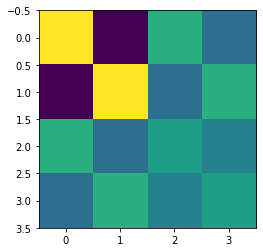

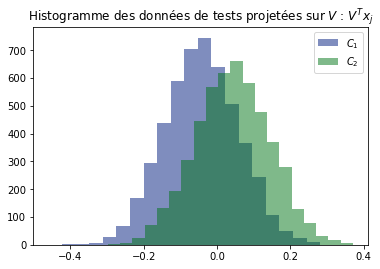

arg q-func : 
[[0.35208916]]
random
beta 0.771320643266746
random
beta 0.0207519493594015
random
beta 0.6336482349262754


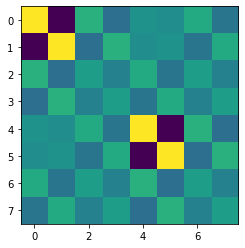

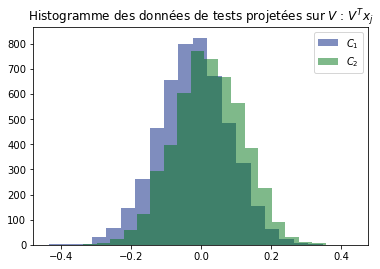

arg q-func : 
[[0.5566617]]
random
beta 0.771320643266746
random
beta 0.0207519493594015
random
beta 0.6336482349262754
random
beta 0.7488038825386119
random
beta 0.4985070123025904


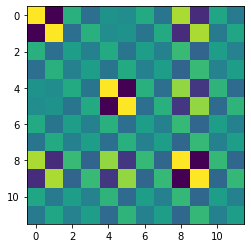

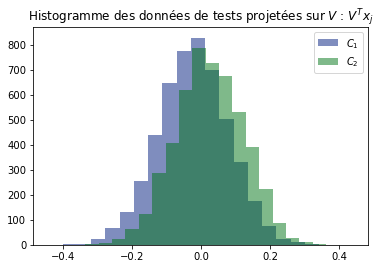

arg q-func : 
[[0.70192908]]
random
beta 0.771320643266746
random
beta 0.0207519493594015
random
beta 0.6336482349262754
random
beta 0.7488038825386119
random
beta 0.4985070123025904
random
beta 0.22479664553084766
random
beta 0.19806286475962398


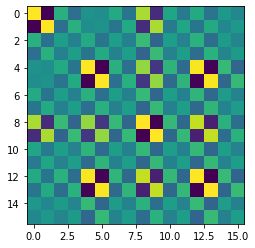

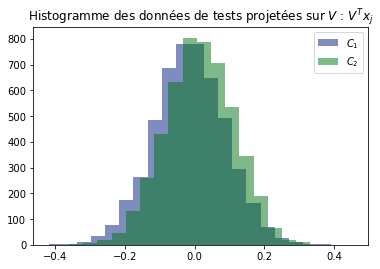

arg q-func : 
[[0.74303538]]
random
beta 0.771320643266746
random
beta 0.0207519493594015
random
beta 0.6336482349262754
random
beta 0.7488038825386119
random
beta 0.4985070123025904
random
beta 0.22479664553084766
random
beta 0.19806286475962398
random
beta 0.7605307121989587
random
beta 0.16911083656253545


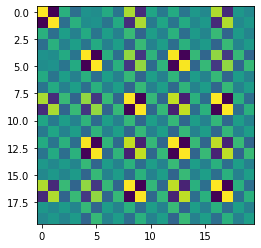

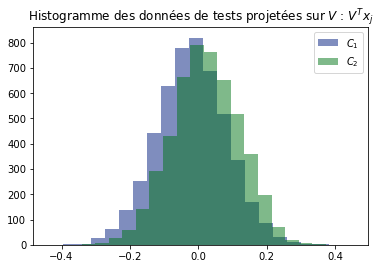

arg q-func : 
[[0.79682328]]
Temps moyen pour (resp.) le calcul des produits scalaires entre moyennes empiriques, l'estimation de M cursive, c et les labels optimaux y, et l'inférence : 0.015513896942138672, 0.00035119056701660156, 0.1427619457244873


In [53]:
# %%prun -s cumulative
# profiling
%matplotlib inline
p = 100
m = 2
# on ajoute des tâches 2 par 2
nb_tasks = 6
t = range(2,2*nb_tasks, 2)
multiple = 1
to_add = [50, 50], [6, 6]
n_t = []
n_t_test = [[5000, 5000]]
nt = sum(n_t_test[0])
# la liste temps comprendra le temps pour le training, le calcul de M et y et le temps d'inférence
emp_rate, th_rate, var, relative_error_rate = [], [], [], []

# temps
temps_MM = 0
temps_estim = 0
temps_inference = 0
t_total_nd = []
random_state = 10

# données envoyées
data_sent_nd = []
task_target = 1
M = mean_matrix(p, beta=None, k=2, random_seed=random_state, random=True)
X_test, y_test = gaussian_synthetic_data(nt, p, m, 1, n_t_test, [M[task_target]], random_state)
X_test = normalisation(X_test, p)

for b in t:
    n_t.append(to_add[0])
    n_t.append(to_add[1])
    
#     print(b)
#     print(n_t)
    n = sum(list(map(sum, (n_t[i] for i in range(b)))))
#     print(n)
    # on crée les données synthétiques
    M = mean_matrix(p, beta=None, k=b, random_seed=random_state, random=True)
       
    if b==2:
        X, y_bs = gaussian_synthetic_data(n, p, m, b, n_t, M, random_state)
    else:
        synth = gaussian_synthetic_data(sum(to_add[0])+sum(to_add[1]), p, m, 2, [n_t[-2],n_t[-1]], [M[-2], M[-1]], random_state)[0]
        X.append(synth[0])
        X.append(synth[1])
    # c'est un pon con parce qu'a chaque fois je recrée les mêmes (k-1)*2 vecteurs gaussiens alors que je pourrais juste les stoker quelque part

# DEBUG
    #MM1, diag1 = empirical_mean_old(1, m, X, p, [n_t[0]])
    # On calcule les moyennes empiriques
    
    t0 = time()
    MM = empirical_mean(b, m, X, p, n_t)
    temps_MM = time() - t0
    # On time le calcul de MTM

    t0 = time()
    c = estimate_c(n_t, n, b, m)
    c0 = p/n
    Dc = np.diag(c)
    correlation_matrix = compute_M_cal(n, p, Dc, MM, display=False)
    y = label_evaluation(b,m,Dc,MM, c0, task_target=task_target)
    temps_estim = time() - t0
    # On time l'estimation de y, M, et c
    
    M_true = true_mean(M, p, b, m)
    MM_true = M_true.T@M_true
    correlation_matrix_true = compute_M_cal(n, p, Dc, MM_true, display=True)
    y_true = label_evaluation(b,m,Dc,MM_true, c0, task_target=task_target)
    X = normalisation(X, p)
    
    X_train_aggregated = aggregate_array(X, p, n, b, m)
    X_test_aggregated = aggregate_array(X_test, p, nt, 1, m)
    
    m_t_true = create_mt(b, m, y_true, Dc, correlation_matrix_true)
    t0 = time()
    J = create_J(m, b, n, n_t)
    V = compute_V(y, X_train_aggregated, J, n)
    V_true = compute_V(y_true, X_train_aggregated, J, n)
    m_t = create_mt(b, m, y, Dc, correlation_matrix)
    erreur_empirique = compute_error_rate(X_test, V_true, m_t_true, 1, m, n_t_test, Dc, c0)
    temps_inference = time() - t0
    # On time le temps d'inférence 
    
    
#     debug_histogram(V_true, X_test_aggregated, n_t_test)
#     print("V = ")
    VTX = V.T@X_test_aggregated
    debug_histogram(V, X_test_aggregated, n_t_test)
    var.append(np.var(VTX))
    
    erreur_theorique = error_rate(b, m,  Dc, MM_true, c0, task_target=task_target)[0][0]
    emp_rate.append(erreur_empirique)
    th_rate.append(erreur_theorique)
    relative_error_rate.append(abs(erreur_empirique - erreur_theorique)/erreur_theorique)
    
    t_total_nd.append(temps_MM + temps_estim)
    data_sent_nd.append(n)
    
# erreur_relative_moy = np.mean(relative_error_rate)
# print(f"Erreur relative moyenne pour n={n} et p={p}, moyennée sur 10 simulations")
# print(erreur_relative_moy)

print(f"Temps moyen pour (resp.) le calcul des produits scalaires entre moyennes empiriques, l'estimation de M cursive, c et les labels optimaux y, et l'inférence : {np.mean(temps_MM)}, {np.mean(temps_estim)}, {np.mean(temps_inference)}")

%matplotlib qt
lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.plot(t, emp_rate, '-o', label='empirical rate')
plt.plot(t, th_rate, '-o', label='theoritical rate')
plt.fill_between(t, lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title("2-class Gaussian mixture transfer error rate")
plt.xlabel("Added Task")
plt.ylabel("error rate")
plt.grid()
plt.show()

[[array([[1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [

In [72]:
lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.plot(range(len(emp_rate)), emp_rate, '-o', label='empirical rate')
plt.plot(range(len(emp_rate)), th_rate, '-o', label='theoritical rate')
plt.fill_between(range(len(emp_rate)), lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title("2-class Gaussian mixture transfer error rate")
plt.xlabel("Added Task")
plt.ylabel("error rate")
plt.grid()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (9,) and (10,)

# Algorithme distribué k tâches 2 classes
Bien que certains résultats du précedent algorithmes sont particulèrement inquiétants, essayons de voir comment distribuer l'algorithme sur plusieurs serveurs.

Par exemple un serveur demande les moyennes des autres serveurs pour pouvoir obtenir des meilleurs résultats en calculant la moyenne des ses données et la moyenne de toutes les moyennes avant de le renvoyer au serveur principal qui mettra à jour le modèle.

Prendre des données synthétiques pour la 1ère tâche à 2 classes, puis rappatrier une ou plusieurs moyennes pour les autres tasks. 
Faire des comparaisons, avec et sans federated learning.

### k serveurs 
#### Federated Learning 2 classes k taches
Imaginons 1 Serveur central et k clients. L'un cherche à classifier un certain type d'images, l'autre un deuxième type d'images. Les deux clients sont confrontés un problème de classification binaire sur des images sensiblement similaire (quantifié par le paramètre $\beta$), et peuvent donc s'aider du training de l'autre pour affiner leur classification.

Le premier client entraîne son modèle de classification sur son jeu de données locales. Il espère obtenir de meilleures performances à l'aide du transfer Learning. Les deux clients envoient alors les moyennes empiriques calculées sur leurs donnée locales, au serveur central. Le serveur peut alors calculé la matrice de corrélation $\mathcal{M}$ et les labels optimaux $\tilde{y}$. Les clients recoivent les labels optimaux, et peuvent maintenant recalculer le vecteur propre $V$ de $\displaystyle\frac{X_ty_ty_t^TX_t^T}{np}$ et inférer sur de nouvelles données $x$.

Calcul des moyennes empiriques, et calcul de la matrice $M\in\mathbb{R}^{p\times 2k}$
$$\frac{1}{n_{tj}}X_{tj}\mathbb{1}_{n_{tj}}=\frac{1}{n_{tj}}\sum_{l=1}^{n_{tj}}x_{tl}^{(j)}$$

Chaque client calcule en local les moyennes empiriques des données et les envoie au serveur central.

De la même façcon que précédemment les données de chaque client (=chaque tâche) devront respecter les conditions de non-trivialité.

In [26]:
def empirical_mean_old(nb_tasks, nb_classes, X, p, n_t):
    """
    compute empirical mean for data 
    retourne la matrice M de taille px(2*k) et un vecteur contenant les coefficients diagonaux
    nb_classes=2 (toujours)
    
    Complexité : 
    -------------
    O(k*p*n_tl) = O(n*p)
    """
    M = np.empty((nb_classes*nb_tasks, p))
    diag = []
    for t in range(nb_tasks):
        # O(k)
        for l in range(nb_classes):
            # O(2)
            M[t*nb_classes+l] = X[t][l].dot(np.ones((n_t[t][l])))
            # O(p*n_tl)
            M[t*nb_classes+l] /= n_t[t][l]
            # O(1)
            
            moitie = int(n_t[t][l]/2)
#             print(f" moitie = {moitie}")
#             print("shape X : ", X[t][l].T[:moitie].T.shape)
            mu1 = 1/moitie*X[t][l].T[:moitie].T@np.ones((moitie))
            mu2 = 1/moitie*X[t][l].T[moitie:2*moitie].T@np.ones((moitie))
#             print("mu shapes before : ")
#             print(mu1.shape)
#             print(mu2.shape)
            # O(p*n_tl)
            mu1, mu2 = np.reshape(mu1, (p, 1)), np.reshape(mu2, (p, 1))
#             print("mu shapes : ")
#             print(mu1.shape)
#             print(mu2.shape)
            diag.append(mu1.T@mu2)
            # O(1)
    
    return M.T, diag

# diag1 = [mu1]
#diag_means = [[mu1], [mu2]]

def gather_empirical_mean(nb_tasks, nb_classes, emp_means, diag_means, p, n_t):
    """
    emp_means est un vecteur contenant les moyennes empiriques de chaque tache de chaque classe.
    Chaque vecteur de moyennes et de taille px1
    Renvoie la matrice M des, produits scalaires entre moyennes empiriques de chaque client
    """
    M = np.empty((nb_classes*nb_tasks, nb_classes*nb_tasks)) # ici 4x4
    for i in range(nb_tasks):
        # O(k)
        for j in range(nb_classes):
            # O(2)
            for k in range(nb_tasks):
                # O(k)
                for l in range(nb_classes):
                    # O(2)
                    if i == k and j == l:
                        #print(f"i = {i}, j = {j}")
#                         print(i*nb_tasks+j, i*nb_tasks+j)
#                         print(moitie)
#                         print(np.ones((moitie, 1)).T.dot(X[i][j].T[:moitie]).shape)
#                         print(emp_means[i*nb_tasks+j][:moitie].T.shape)
                        M[i*nb_classes+j][i*nb_classes+j] = diag_means[i*nb_classes+j]
                    else:
#                         print(i*nb_tasks+j, k*nb_tasks+l)
#                         print(emp_means[i*nb_tasks+j].T.shape)
#                         print(emp_means[k*nb_tasks+l].shape)
                        M[i*nb_classes+j][k*nb_classes+l] = emp_means[i*nb_classes+j].T.dot(emp_means[k*nb_classes+l])
                    # O(p)
#                         print(M[i*nb_tasks+j][k*nb_tasks+l].shape)
                
    return M

In [27]:
def merging_center(MM, diag, t, m, p, n, n_t, task_target=None, display=False):
    """
    Recoit les moyennes empiriques des k clients, calcule la matrice de corrélation, les labels optimaux et renvoie le vecteur V
    Renvoie y un vecteur de labels optimaux adapté à chaque client. (à changer?)
    """
    # MM = [[MM11, MM12], [MM21, MM22], [MM31, MM32], ...]
    emp_means = []
    diagonal = []
    
    for i in range(len(MM)):
        for l in range(m):
            emp_means.append(np.reshape(MM[i].T[l], (p, 1)))
            diagonal.append(diag[i][l])
    #diag = [diag1[0], diag1[1], etc.]
    #emp_means = [MM11, MM12, MM21, MM22, MM31, ...]
    MM_gathered = gather_empirical_mean(t, m, emp_means, diagonal, p, n_t)
    if display:
        print("MM_gathered : ")
        matprint(MM_gathered)
    
    c = estimate_c(n_t, n, t, m)
    c0 = p/n
    Dc = np.diag(c)
    correlation_matrix = compute_M_cal(n, p, Dc, MM_gathered, display=display)
    y = label_evaluation(t,m,Dc,MM_gathered, c0, task_target=task_target)
    if display:
        matprint(y)
    
    # le serveur calcule aussi
    V = np.zeros((p,1))
    for i in range(t):
        for j in range(m):
            V += n_t[i][j]*emp_means[i*m+j]*y[i*m+j]
#     print(f"V = {V}")
      # pourquoi on a touours le meme V ?
#     V = V.astype("float128")
    V /= np.linalg.norm(V)
    V = np.reshape(V, (p))
    
    return V, y, correlation_matrix, Dc, c0

In [34]:
%matplotlib inline
n1 = 4000
n2 = 200
n = n1+n2
p = 200
m = 2
t = 2
ni = [n1, n2]
beta = np.linspace(0,1,10)
n_t = [[int(n1/2),int(n1/2)], [int(n2/2), int(n2/2)]]
n_t_test = [[1000, 1000]]
nt = sum(n_t_test[0])
emp_rate, th_rate, var = [], [], []

t_MM = []
t_SC = []
t_inf = []
t_MM_f = []
t_inf_f = []

random_state = 100
task_target = 1

for b in beta:
    # on crée les données synthétiques
    M = mean_matrix(p, b, t, random_seed=random_state)
#       print(M)
    # X1 is the local data of the first client
    # normalisation?
    X, y_bs = gaussian_synthetic_data(n, p, m, t, n_t, M, random_state)
    
    # data we want to test on our model, here new data of client n°2
    X_test, y_test = gaussian_synthetic_data(nt, p, m, 1, n_t_test, [M[task_target]], random_state)
    
    MM = []
    diag = []
#     X = normalisation(X, p)
    X_test = normalisation(X_test, p)
    
    # On calcule les moyennes empiriques sur les données locales
    # diag1 = [diag1[0], diag1[1]]
    for i in range(t):
        t0 = time()
        MM1, diag1 = empirical_mean_old(1, m, [X[i]], p, [n_t[i]])
        t_MM.append(time()-t0)
        MM.append(MM1)
        diag.append(diag1)

# CENTRAL SERVER
    t0 = time()
    # sending empirical means to central server
    # y est un vecteur de vecteurs de labels optimaux
    V, y, correlation_matrix, Dc, c0 = merging_center(MM, diag, t, m, p, n, n_t, task_target)
    t_SC.append(time()-t0)
    matprint(correlation_matrix)
    
# END CENTRAL SERVER

    # Sending back optimal labels to clients
    aggregated = []
    for i in range(t):
        aggregated.append(aggregate_array([X[i]], p, ni[i], 1, m))
    X_test_aggregated = aggregate_array(X_test, p, nt, 1, m)
    # ou alors créer un J ?
#     J = create_J(m, 2, n, n_t)
    
    VTX = V.T@X_test_aggregated
    var.append(np.var(VTX))
    
#     debug_histogram(V, X_test_aggregated, n_t_test)
#     print("V = ")
#     print(V)
    t0 = time()
    m_t = create_mt(t, m, y, Dc, correlation_matrix)
    
    emp_rate.append(compute_error_rate(X_test, V, m_t, 1, m, n_t_test, Dc, c0))
    t_inf.append(time()-t0)
#     th_rate.append(error_rate(t, m,  Dc, MM_true, c0)[0][0])
#     print(emp_rate, th_rate)
    t_MM_f.append(max(t_MM))
    t_inf_f.append(max(t_inf))
    
# pour pas le recalculer a chaque fois 
th_rate = [0.23975006109347674, 0.23910189492427802, 0.23712834068265354, 0.23373859215337528, 0.2287682743173643, 0.22195637062121154, 0.2129043075952785, 0.20100393554334806, 0.18530737544421827, 0.16428249171959852]   

print(f"temps moyen clients : {round(np.mean(t_MM_f), 5)}, {round(np.mean(t_inf_f), 5)}")
print(f"temps moyen Serveur central : {round(np.mean(t_SC), 5)}")
print(f"temps total moyen : {round(np.mean(t_MM_f), 5) + round(np.mean(t_inf_f), 5) + round(np.mean(t_SC), 5)}")

%matplotlib qt

lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.plot(beta, emp_rate, '-o', label='empirical rate')
plt.plot(beta, th_rate, '-v', label='theoritical rate')
plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title(f"2-class Gaussian mixture transfer error rate for n={n} and p={p}")
plt.xlabel("Task relatedness (beta)")
plt.ylabel("error rate")
plt.grid()
plt.show()

   5.12642  -4.95681   -0.10579  -0.0402121  
  -4.95681   4.92311   0.209975    0.105015  
  -0.10579  0.209975   0.275235   -0.210616  
-0.0402121  0.105015  -0.210616    0.201076  
  5.12642   -4.95681  0.0183977  -0.164399  
 -4.95681    4.92311  0.0857741   0.229216  
0.0183977  0.0857741   0.266325  -0.208622  
-0.164399   0.229216  -0.208622   0.205998  
  5.12642    -4.95681    0.142218  -0.288219  
 -4.95681     4.92311  -0.0386454   0.353635  
 0.142218  -0.0386454    0.257466  -0.206466  
-0.288219    0.353635   -0.206466   0.210544  
 5.12642   -4.95681   0.265648   -0.41165  
-4.95681    4.92311  -0.163296   0.478286  
0.265648  -0.163296   0.248661  -0.204136  
-0.41165   0.478286  -0.204136    0.21469  
  5.12642   -4.95681   0.388647  -0.534649  
 -4.95681    4.92311  -0.288204   0.603194  
 0.388647  -0.288204   0.239915  -0.201615  
-0.534649   0.603194  -0.201615   0.218394  
  5.12642   -4.95681   0.511141  -0.657143  
 -4.95681    4.92311  -0.413411   0.728401  
 0

In [ ]:
4.75962   -4.8477    1.08341  -0.892901  
  -4.8477   5.00614    -1.1252   0.959628  
  1.08341   -1.1252   0.327581  -0.326737  
-0.892901  0.959628  -0.326737   0.228697 

In [33]:
th_rate = [0.23975006109347674, 0.23910189492427802, 0.23712834068265354, 0.23373859215337528, 0.2287682743173643, 0.22195637062121154, 0.2129043075952785, 0.20100393554334806, 0.18530737544421827, 0.16428249171959852]   

print(f"temps moyen clients (calcul moyennes, inférence): {round(np.mean(t_MM_f), 5)} s, {round(np.mean(t_inf_f), 5)} s")
print(f"temps moyen Serveur central : {round(np.mean(t_SC), 5)} s")
print(f"temps total moyen : {round(np.mean(t_MM_f), 5) + round(np.mean(t_inf_f), 5) + round(np.mean(t_SC), 5)} s")

lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.plot(beta, emp_rate, '-o', label='empirical rate')
plt.plot(beta, th_rate, '-o', label='theoritical rate')
plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title(f"2-class Gaussian mixture transfer error rate for n={n} and p={p}")
plt.xlabel("Task relatedness (beta)")
plt.ylabel("error rate")
plt.grid()
plt.show()

temps moyen clients (calcul moyennes, inférence): 0.00101 s, 0.01589 s
temps moyen Serveur central : 0.00044 s
temps total moyen : 0.01734 s


# Distributively adding tasks

random
beta 0.771320643266746
random
beta 0.771320643266746
task 1 empirical mean = -0.05101151671608839
task 1 empirical mean = -0.1685920178688018
MM_gathered : 
0.966294   -1.02803   0.760029  -1.02895  
-1.02803    1.15724  -0.709761   1.04108  
0.760029  -0.709761    1.28922  -1.21604  
-1.02895    1.04108   -1.21604   1.17272  


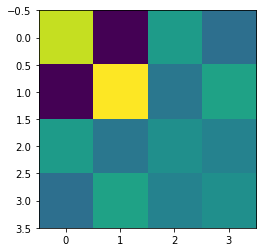

  2.28873  
-0.198828  
  17.2836  
 -8.84764  
[[0.47619048 0.         0.         0.        ]
 [0.         0.47619048 0.         0.        ]
 [0.         0.         0.02380952 0.        ]
 [0.         0.         0.         0.02380952]]


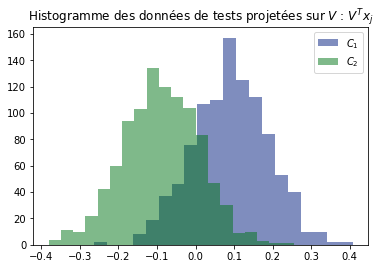

arg q-func : 
[[0.69764454]]
random
beta 0.771320643266746
random
beta 0.0207519493594015
random
beta 0.6336482349262754
task 1 empirical mean = -0.05101151671608839
task 1 empirical mean = -0.1685920178688018
task 1 empirical mean = 0.03963968183321687
task 1 empirical mean = 0.025913976930101168
MM_gathered : 
  0.966294    -1.02803   0.760029   -1.02895    0.107645  -0.0591596   0.773973  -0.739651  
  -1.02803     1.15724  -0.709761    1.04108  -0.0498879  -0.0481287  -0.838802   0.791798  
  0.760029   -0.709761    1.28922   -1.21604    0.847901   -0.991683    1.17581  -0.501109  
  -1.02895     1.04108   -1.21604    1.17272   -0.500232    0.568762   -1.01578   0.994008  
  0.107645  -0.0498879   0.847901  -0.500232    0.896748    -0.97198   0.713891  -0.651659  
-0.0591596  -0.0481287  -0.991683   0.568762    -0.97198     1.05391  -0.761442   0.602214  
  0.773973   -0.838802    1.17581   -1.01578    0.713891   -0.761442    0.96289  -0.841908  
 -0.739651    0.791798  -0.501109  

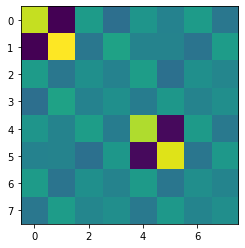

  4.5616  
-3.71555  
-6.88254  
 3.24973  
-1.52588  
-8.04365  
-6.81939  
 21.3332  
[[0.23809524 0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.23809524 0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.01190476 0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.01190476 0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.23809524 0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.23809524
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.01190476 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.01190476]]


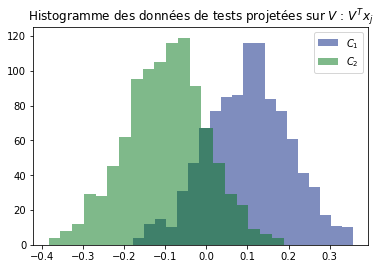

arg q-func : 
[[0.95720706]]
random
beta 0.771320643266746
random
beta 0.0207519493594015
random
beta 0.6336482349262754
random
beta 0.7488038825386119
random
beta 0.4985070123025904
task 1 empirical mean = -0.05101151671608839
task 1 empirical mean = -0.1685920178688018
task 1 empirical mean = 0.03963968183321687
task 1 empirical mean = 0.025913976930101168
task 1 empirical mean = -0.04280576502257588
task 1 empirical mean = -0.017713268389584813
MM_gathered : 
  0.966294    -1.02803   0.760029   -1.02895    0.107645  -0.0591596   0.773973  -0.739651   0.740781  -0.802561   0.432282  -0.441904  
  -1.02803     1.15724  -0.709761    1.04108  -0.0498879  -0.0481287  -0.838802   0.791798  -0.724076   0.817653   -0.35953   0.483057  
  0.760029   -0.709761    1.28922   -1.21604    0.847901   -0.991683    1.17581  -0.501109    1.16579   -1.12139    1.13622   -1.15153  
  -1.02895     1.04108   -1.21604    1.17272   -0.500232    0.568762   -1.01578   0.994008   -1.05599     1.0656   -1.0535

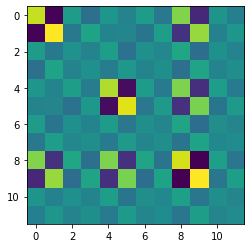

 5.89171  
-4.91164  
-21.0855  
 15.9832  
-5.64547  
 -12.221  
-14.4616  
 26.3573  
 3.79259  
 1.60358  
 23.2759  
-43.2694  
[[0.15873016 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.15873016 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.00793651 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.00793651 0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.15873016 0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.15873016
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.00793651 0.         0.

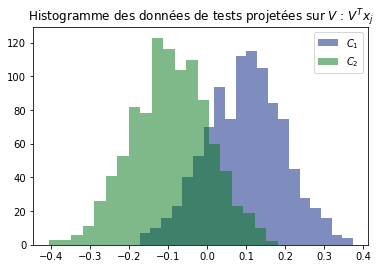

arg q-func : 
[[0.97734742]]
random
beta 0.771320643266746
random
beta 0.0207519493594015
random
beta 0.6336482349262754
random
beta 0.7488038825386119
random
beta 0.4985070123025904
random
beta 0.22479664553084766
random
beta 0.19806286475962398
task 1 empirical mean = -0.05101151671608839
task 1 empirical mean = -0.1685920178688018
task 1 empirical mean = 0.03963968183321687
task 1 empirical mean = 0.025913976930101168
task 1 empirical mean = -0.04280576502257588
task 1 empirical mean = -0.017713268389584813
task 1 empirical mean = 0.020810101033053877
task 1 empirical mean = 0.14197243830540557
MM_gathered : 
  0.966294    -1.02803   0.760029   -1.02895    0.107645  -0.0591596   0.773973  -0.739651   0.740781  -0.802561   0.432282  -0.441904   0.311772  -0.228704   0.433141  -0.164405  
  -1.02803     1.15724  -0.709761    1.04108  -0.0498879  -0.0481287  -0.838802   0.791798  -0.724076   0.817653   -0.35953   0.483057  -0.251151   0.183502  -0.387027  0.0663466  
  0.760029   -0.70

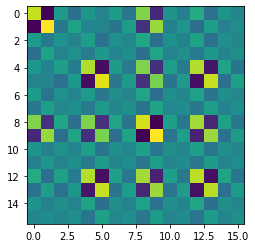

 8.89429  
 -6.9507  
-37.5588  
 23.4224  
-5.42437  
-19.7299  
-15.9867  
 33.3831  
 6.41716  
 2.65966  
 30.0182  
-65.6226  
-7.57349  
-1.92579  
-24.3093  
-3.59186  
[[0.11904762 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.11904762 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.00595238 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.00595238 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.11904762 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0

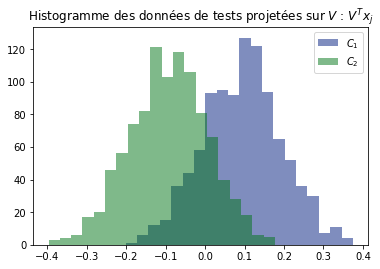

arg q-func : 
[[0.981079]]
random
beta 0.771320643266746
random
beta 0.0207519493594015
random
beta 0.6336482349262754
random
beta 0.7488038825386119
random
beta 0.4985070123025904
random
beta 0.22479664553084766
random
beta 0.19806286475962398
random
beta 0.7605307121989587
random
beta 0.16911083656253545
task 1 empirical mean = -0.05101151671608839
task 1 empirical mean = -0.1685920178688018
task 1 empirical mean = 0.03963968183321687
task 1 empirical mean = 0.025913976930101168
task 1 empirical mean = -0.04280576502257588
task 1 empirical mean = -0.017713268389584813
task 1 empirical mean = 0.020810101033053877
task 1 empirical mean = 0.14197243830540557
task 1 empirical mean = 0.010513175950733977
task 1 empirical mean = 0.03297791622761381
MM_gathered : 
  0.966294    -1.02803   0.760029   -1.02895    0.107645  -0.0591596   0.773973  -0.739651   0.740781  -0.802561   0.432282  -0.441904   0.311772  -0.228704   0.433141  -0.164405   0.765777  -0.773855   0.317833  -0.300786  
  -1.

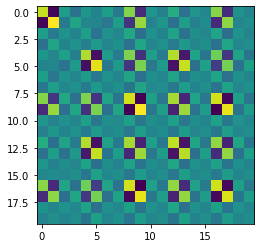

  8.03357  
 -7.87021  
 -56.8041  
  35.8228  
 -9.19173  
 -24.4047  
 -24.7961  
  55.2639  
  5.86326  
  5.12995  
   46.074  
 -75.2094  
 -12.1781  
 -1.38349  
 -25.8587  
 -5.86495  
-0.443908  
 -12.3179  
  3.45371  
   -35.84  
[[0.0952381 0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.       ]
 [0.        0.0952381 0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.0047619 0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.0047619 0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.       

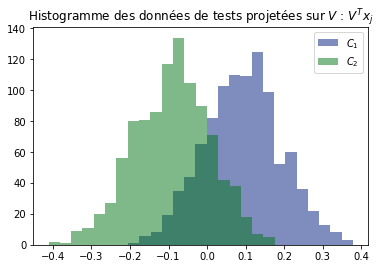

arg q-func : 
[[0.98626563]]
random
beta 0.771320643266746
random
beta 0.0207519493594015
random
beta 0.6336482349262754
random
beta 0.7488038825386119
random
beta 0.4985070123025904
random
beta 0.22479664553084766
random
beta 0.19806286475962398
random
beta 0.7605307121989587
random
beta 0.16911083656253545
random
beta 0.08833981417401027
random
beta 0.6853598183677972
task 1 empirical mean = -0.05101151671608839
task 1 empirical mean = -0.1685920178688018
task 1 empirical mean = 0.03963968183321687
task 1 empirical mean = 0.025913976930101168
task 1 empirical mean = -0.04280576502257588
task 1 empirical mean = -0.017713268389584813
task 1 empirical mean = 0.020810101033053877
task 1 empirical mean = 0.14197243830540557
task 1 empirical mean = 0.010513175950733977
task 1 empirical mean = 0.03297791622761381
task 1 empirical mean = 0.0302281783401204
task 1 empirical mean = -0.14058510448002937
MM_gathered : 
  0.966294     -1.02803   0.760029   -1.02895    0.107645  -0.0591596   0.773

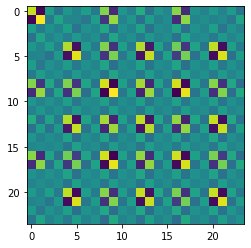

  11.3533  
 -8.80707  
 -69.8318  
  53.5548  
    -11.4  
 -29.8396  
 -30.0606  
  65.0113  
   6.6088  
  7.85756  
   40.366  
 -99.7311  
 -17.4967  
-0.682041  
 -40.8276  
  -10.078  
  2.19982  
 -12.5794  
  4.04859  
 -36.5983  
 0.647789  
 -4.11638  
 -21.0696  
 -55.4016  
[[0.07936508 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.07936508 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.00396825 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        

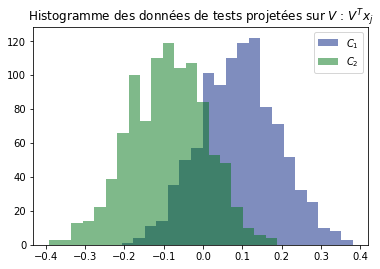

arg q-func : 
[[0.98684951]]
random
beta 0.771320643266746
random
beta 0.0207519493594015
random
beta 0.6336482349262754
random
beta 0.7488038825386119
random
beta 0.4985070123025904
random
beta 0.22479664553084766
random
beta 0.19806286475962398
random
beta 0.7605307121989587
random
beta 0.16911083656253545
random
beta 0.08833981417401027
random
beta 0.6853598183677972
random
beta 0.9533933461949365
random
beta 0.003948266327914451
task 1 empirical mean = -0.05101151671608839
task 1 empirical mean = -0.1685920178688018
task 1 empirical mean = 0.03963968183321687
task 1 empirical mean = 0.025913976930101168
task 1 empirical mean = -0.04280576502257588
task 1 empirical mean = -0.017713268389584813
task 1 empirical mean = 0.020810101033053877
task 1 empirical mean = 0.14197243830540557
task 1 empirical mean = 0.010513175950733977
task 1 empirical mean = 0.03297791622761381
task 1 empirical mean = 0.0302281783401204
task 1 empirical mean = -0.14058510448002937
task 1 empirical mean = 0.00

-0.0767211      0.12244   0.890948  -0.364253    0.794018   -0.845225   0.525017  0.0400345   0.459284  -0.432442   0.800818  -0.569319   0.761951  -0.740842   0.866846  -0.738265   0.409086   -0.41668   0.971879  -0.761201    0.716954    -0.878421   0.731777  -0.254424  0.0320643  -0.101265    0.830593  -0.779269  
 -0.208039    0.0738754   -1.51924   0.416474   -0.955663    0.953094   -1.09103   0.453804  -0.830554   0.768807   -0.60371   0.888702  -0.961391    1.01883   -1.01998    0.87803   -0.69448   0.787329   -1.16901   0.972442   -0.981582     0.962204  -0.930913   0.447195  -0.488698   0.413107   -0.779269   0.310406  


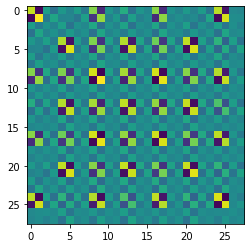

 15.5231  
-21.6294  
 -197.76  
 80.8763  
-21.4784  
-42.6966  
-39.9088  
 40.8709  
 13.6357  
 1.47149  
 99.4068  
-162.417  
-27.5611  
 5.90487  
 -62.163  
 12.3878  
 9.98145  
-15.9374  
-10.4983  
-13.9757  
-1.92209  
-3.25766  
-17.4323  
-111.859  
-29.0126  
 1.31234  
 48.9544  
-254.641  
[[0.06802721 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.06802721 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.00340136 0.         0.         0.
  0.         0.         0.         0.         0.         0

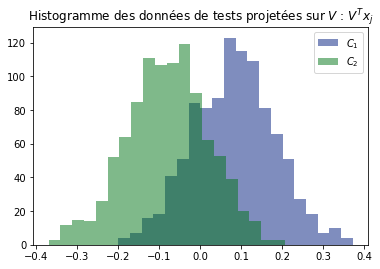

arg q-func : 
[[0.99004742]]
random
beta 0.771320643266746
random
beta 0.0207519493594015
random
beta 0.6336482349262754
random
beta 0.7488038825386119
random
beta 0.4985070123025904
random
beta 0.22479664553084766
random
beta 0.19806286475962398
random
beta 0.7605307121989587
random
beta 0.16911083656253545
random
beta 0.08833981417401027
random
beta 0.6853598183677972
random
beta 0.9533933461949365
random
beta 0.003948266327914451
random
beta 0.5121922633857766
random
beta 0.8126209616521135
task 1 empirical mean = -0.05101151671608839
task 1 empirical mean = -0.1685920178688018
task 1 empirical mean = 0.03963968183321687
task 1 empirical mean = 0.025913976930101168
task 1 empirical mean = -0.04280576502257588
task 1 empirical mean = -0.017713268389584813
task 1 empirical mean = 0.020810101033053877
task 1 empirical mean = 0.14197243830540557
task 1 empirical mean = 0.010513175950733977
task 1 empirical mean = 0.03297791622761381
task 1 empirical mean = 0.0302281783401204
task 1 empi

  0.136786   -0.0650698   0.836086  -0.611959    0.943416    -1.00005   0.791096  -0.644734   0.758067  -0.752745   0.799074  -0.744761   0.965872  -0.953825    1.14918  -0.815442   0.712045  -0.735155    0.96735  -0.950735    0.967527    -0.999512    1.01959  -0.778594   0.393472  -0.341689    0.716954  -0.981582   0.953251  -0.873895   0.417547  -0.655325  
-0.0706709  -0.00324887  -0.844738   0.537043    -0.99066     1.02887   -0.78833   0.637818  -0.739884   0.733206  -0.907867   0.763914  -0.983934   0.982825   -1.12417   0.909132  -0.677388   0.697136   -1.05893   0.821928   -0.999512      1.05682   -1.04993   0.796146  -0.342883   0.335525   -0.878421   0.962204  -0.937195    0.87033  -0.390931   0.578985  
  0.659126     -0.77166    1.43206   -1.04763    0.892242    -1.09385    1.35709   -1.12855    1.20845   -1.20917      1.002   -1.00517    1.16182   -1.15023    1.07175  -0.920034    1.25006    -1.1308     1.2483  -0.835018     1.01959     -1.04993    2.10485   -1.56829     1

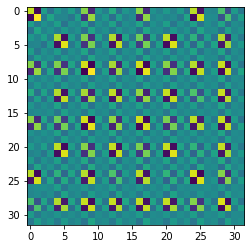

 12.0513  
-30.8387  
-270.526  
 178.507  
-34.0805  
-52.3903  
-116.402  
 -59.464  
 19.3168  
 12.3427  
 147.492  
-288.913  
-15.0343  
 8.59888  
-103.633  
 36.7336  
 10.9057  
-25.2943  
 -36.637  
-50.4449  
-16.2069  
-1.40633  
-66.4952  
-139.561  
-27.1257  
 7.13511  
 109.109  
-323.468  
 20.0302  
 12.7094  
-228.418  
-153.612  
[[0.05952381 0.         0.         ... 0.         0.         0.        ]
 [0.         0.05952381 0.         ... 0.         0.         0.        ]
 [0.         0.         0.00297619 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.05952381 0.         0.        ]
 [0.         0.         0.         ... 0.         0.00297619 0.        ]
 [0.         0.         0.         ... 0.         0.         0.00297619]]


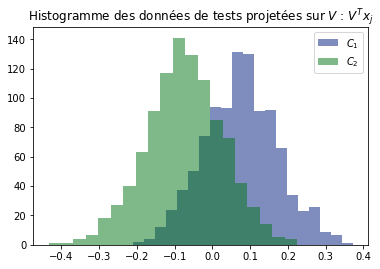

arg q-func : 
[[0.99124149]]
random
beta 0.771320643266746
random
beta 0.0207519493594015
random
beta 0.6336482349262754
random
beta 0.7488038825386119
random
beta 0.4985070123025904
random
beta 0.22479664553084766
random
beta 0.19806286475962398
random
beta 0.7605307121989587
random
beta 0.16911083656253545
random
beta 0.08833981417401027
random
beta 0.6853598183677972
random
beta 0.9533933461949365
random
beta 0.003948266327914451
random
beta 0.5121922633857766
random
beta 0.8126209616521135
random
beta 0.6125260668293881
random
beta 0.7217553174317995
task 1 empirical mean = -0.05101151671608839
task 1 empirical mean = -0.1685920178688018
task 1 empirical mean = 0.03963968183321687
task 1 empirical mean = 0.025913976930101168
task 1 empirical mean = -0.04280576502257588
task 1 empirical mean = -0.017713268389584813
task 1 empirical mean = 0.020810101033053877
task 1 empirical mean = 0.14197243830540557
task 1 empirical mean = 0.010513175950733977
task 1 empirical mean = 0.0329779162

-0.0706709  -0.00324887  -0.844738   0.537043    -0.99066     1.02887   -0.78833   0.637818  -0.739884   0.733206  -0.907867   0.763914  -0.983934   0.982825   -1.12417   0.909132  -0.677388   0.697136   -1.05893   0.821928   -0.999512      1.05682   -1.04993   0.796146  -0.342883   0.335525   -0.878421   0.962204  -0.937195    0.87033  -0.390931   0.578985  -0.842177   0.729632  -0.865137   0.533493  
  0.659126     -0.77166    1.43206   -1.04763    0.892242    -1.09385    1.35709   -1.12855    1.20845   -1.20917      1.002   -1.00517    1.16182   -1.15023    1.07175  -0.920034    1.25006    -1.1308     1.2483  -0.835018     1.01959     -1.04993    2.10485   -1.56829     1.0078  -0.924941    0.731777  -0.930913    1.26358   -1.13479   0.765384   -1.17118    1.15891   -1.20455   0.860616  -0.615651  
 -0.915232      1.02521   -1.44604    1.47931   -0.707556    0.783677   -1.27891    1.14408   -1.19313    1.27217   -1.15107    0.74637  -0.989272   0.898143   -1.14998   0.600598   -1.164

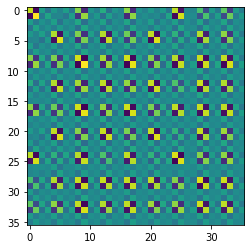

 8.30229  
-36.9164  
 -310.25  
 232.463  
-44.8837  
 -54.317  
 -136.73  
-82.1085  
 23.8634  
 20.1872  
 140.675  
-345.793  
-23.3007  
 14.7219  
-112.395  
 33.0672  
 4.07929  
-20.9689  
-45.5848  
-57.8329  
-11.0854  
 3.46418  
 -65.335  
-191.175  
-34.3917  
 7.80412  
 170.193  
-377.743  
 24.6053  
 13.6334  
-321.601  
-160.257  
 14.1973  
-18.3538  
 71.4078  
-129.477  
[[0.05291005 0.         0.         ... 0.         0.         0.        ]
 [0.         0.05291005 0.         ... 0.         0.         0.        ]
 [0.         0.         0.0026455  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.05291005 0.         0.        ]
 [0.         0.         0.         ... 0.         0.0026455  0.        ]
 [0.         0.         0.         ... 0.         0.         0.0026455 ]]


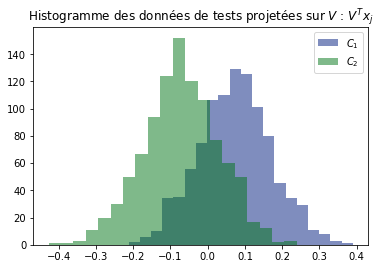

arg q-func : 
[[0.99229516]]


In [36]:
# %%prun -s cumulative
%matplotlib inline
# profiling
p = 100
m = 2
# on ajoute des tâches 2 par 2
nb_tasks = 6
step = 2
t = range(2,step*nb_tasks, step)
multiple = 1
to_add = [1000, 1000], [50, 50]
n_t = []
n_t_test = [[1000, 1000]]
nt = sum(n_t_test[0])
# la liste temps comprendra le temps pour le training, le calcul de M et y et le temps d'inférence
emp_rate, th_rate, var, relative_error_rate = [], [], [], []

# temps
t_SC = 0
t_inf = []
t_MM_f = 0
t_inf_f = 0
t_total_d = []
t_SC_d = []
random_state = 10

# données envoyées de taille p
data_sent = []

# on définit la tache cible
task_target = 1

M = mean_matrix(p, beta=None, k=2, random_seed=random_state, random=True)
X_test, y_test = gaussian_synthetic_data(nt, p, m, 1, n_t_test, [M[task_target]], random_state)
mean_test = M[task_target]
# print("norme tâche de test : ", np.linalg.norm(X_test_aggregated))
X_test = normalisation(X_test, p)

for b in t:
    t_MM = []
    sent = 0
    for i in range(step):
        n_t.append(to_add[i])
    
    n = sum(list(map(sum, (n_t[i] for i in range(b)))))
#     print("n = ", n)
    # on crée les données synthétiques
    M = mean_matrix(p, beta=None, k=b, random_seed=random_state, random=True)
#     print(f"Test mean: {mean_test[0]==M[1][0]}") # True
       
    X, y_bs = gaussian_synthetic_data(n, p, m, b, n_t, M, random_state)
    MM = []
    diag = []
#     X = normalisation(X, p)
    
    # On calcule les moyennes empiriques sur les données locales de chaque serveur
    # diag1 = [diag1[0], diag1[1]]
    for i in range(b):
        t0 = time()
        MM1, diag1 = empirical_mean_old(1, m, [X[i]], p, [n_t[i]])
        print(f"task 1 empirical mean = {np.mean(MM1[0])}")
        # chaque moyenne empirique calculée est un vecteur de taille p
        sent+=1
        t_MM.append(time()-t0)
        
        MM.append(MM1)
        diag.append(diag1)

    # CENTRAL SERVER
    t0 = time()
    # sending empirical means to central server
    V, y, correlation_matrix, Dc, c0 = merging_center(MM, diag, b, m, p, n, n_t, task_target, True)   
    #V_true, y_true, correlation_matrix_true, Dc, c0 = merging_center(M_true, diag_true, b, m, p, n_t, task_target)
    t_SC = time()-t0
    print(Dc)
    
    # END CENTRAL SERVER
    # a prendre en compte dans le timing
    
    X_train_aggregated = aggregate_array(X, p, n, b, m)
    X_test_aggregated = aggregate_array(X_test, p, nt, 1, m)
    # On time le temps d'inférence
    
    # Calcul avec les vraies moyennes
    M_true = true_mean(M, p, b, m)
    MM_true = M_true.T@M_true
    correlation_matrix_true = compute_M_cal(n, p, Dc, MM_true, display=False)
    y_true = label_evaluation(b,m,Dc, MM_true, c0, task_target=task_target)
    
#     V_true = compute_V(y_true, X_train_aggregated, J, n)
#     debug_histogram(V_true, X_test_aggregated, n_t_test)
#     print("V = ")
#     test pour vérifier le calcul de V dans le serveur: tout est bon
#     J = create_J(m, b, n, n_t)
#     V = compute_V(y, X_train_aggregated, J, n)
    VTX = V.T@X_test_aggregated
    var.append(np.var(VTX))
    debug_histogram(V, X_test_aggregated, n_t_test)
    
    t0 = time()
    m_t = create_mt(b, m, y, Dc, correlation_matrix)
    
    erreur_theorique = error_rate(b, m,  Dc, MM_true, c0)[0][0]
    emp_rate.append(compute_error_rate(X_test, V, m_t, 1, m, n_t_test, Dc, c0))
    th_rate.append(erreur_theorique)
    t_inf.append(time()-t0)
    t_MM_f = max(t_MM)
    t_inf_f = max(t_inf)
    t_total_d.append(t_MM_f + t_SC)
    t_SC_d.append(t_SC)
    data_sent.append(sent)

# print(f"temps moyen clients : {round(np.mean(t_MM_f), 5)}, {round(np.mean(t_inf_f), 5)}")
# print(f"temps moyen Serveur central : {round(np.mean(t_SC), 5)}")
# print(f"temps total moyen : {round(np.mean(t_MM_f), 5) + round(np.mean(t_inf_f), 5) + round(np.mean(t_SC), 5)}")

In [44]:
print(data_sent)
print(data_sent_nd)
print(t_SC_d)
print(t_total_d)
print(th_rate)

[2, 4, 6, 8, 10]
[2100, 4200, 6300, 8400, 10500]
[0.21463251113891602, 0.1909496784210205, 0.1764202117919922, 0.28003716468811035, 0.3195788860321045]
[0.215956449508667, 0.19174504280090332, 0.17744803428649902, 0.2811012268066406, 0.32141757011413574]
[0.22280175195202867, 0.16330704986164485, 0.16180137712313486, 0.1606472022307061, 0.1602570784068436]


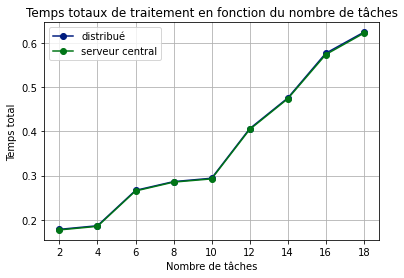

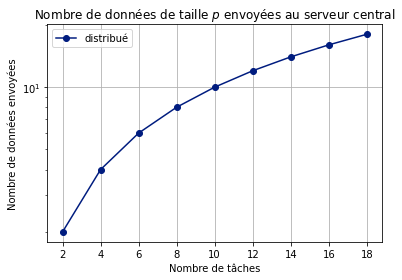

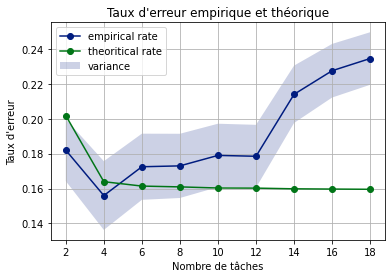

In [37]:
# plot le temps du distribué vs non distribué
plt.plot(data_sent, t_total_d, '-o', label='distribué')
plt.plot(data_sent, t_SC_d, '-o', label='serveur central')
# plt.plot(t, t_total_nd, '-o', label='non distribué')
plt.xlabel("Nombre de tâches")
plt.ylabel("Temps total")
plt.title("Temps totaux de traitement en fonction du nombre de tâches")
plt.legend()
plt.grid()
plt.show()

plt.plot(data_sent, data_sent, "-o", label='distribué')
# plt.plot(t, data_sent_nd, '-o', label='non distribué')
plt.xlabel("Nombre de tâches")
plt.ylabel("Nombre de données envoyées")
plt.yscale("log")
plt.title(r"Nombre de données de taille $p$ envoyées au serveur central")
plt.legend()
plt.grid()
plt.show()

lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.fill_between(data_sent, lower, upper, alpha=0.2, label="variance")
plt.plot(data_sent, emp_rate, "-o", label='empirical rate')
plt.plot(data_sent, th_rate, '-o', label='theoritical rate')
plt.xlabel("Nombre de tâches")
plt.ylabel("Taux d'erreur")
plt.title(r"Taux d'erreur empirique et théorique")
plt.legend()
plt.grid()
plt.show()

# Real Data

In [24]:
def normalisation(X, p, z=False):
    """
    si z: z-score normalisation par tâche
    sinon: divsion par sqrt(p)
    """
    if not z:
        for i in range(len(X)):
            for j in range(len(X[i])):
                X[i][j] *= 1/np.sqrt(p)
    else:
        for i in range(len(X)):
            task = np.concatenate((X[i][0], X[i][1]), axis=1)
            mean = np.mean(task, axis=1)
            mean = np.reshape(mean, (p, 1))
            X[i][0] = (X[i][0] - mean)/np.std(task)
            X[i][1] = (X[i][1] - mean)/np.std(task)
    return X

In [26]:
from sklearn import preprocessing

def divide_array(X,y,k,m=2):
    """
    Divide a data ndarray in an array of k arrays of m ndarrays each.
    Return the divided array and the number of elements in each classes of each tasks
    """
    X_data = []
    n_t = []
    for task in range(k):
        n_t.append([])
        X_data.append([])
        n_t1 = np.count_nonzero(y)
        n_t[task].append(n_t1)
        n_t[task].append(len(y) - n_t1)
        X_data[task].append(X[:n_t1].T)
        X_data[task].append(X[n_t1:].T)
        
    return X_data, n_t

def preprocess(X, p):
    """
    Centre et réduit les données X
    """
    tiled = np.tile(np.reshape(np.sum(X, axis=0), (p, 1)), (1, X.shape[0])).T
    X_t = np.true_divide(X, tiled, where=(tiled!=0))
    return preprocessing.scale(X, axis=0)
    

(400, 999) (400, 1000)
[[999, 1000]]
[[80, 200], [400, 20]]
n :  700
lenMM : 2
MM_gathered : 
  0.905682    -1.53159    0.0618304    -0.0484037  
  -1.53159    0.824589   -0.0665062     0.0954148  
 0.0618304  -0.0665062    0.0047108   -0.00623109  
-0.0484037   0.0954148  -0.00623109  -0.000383289  


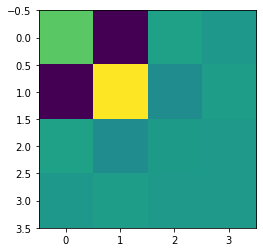

   0.0383687  
   -0.191739  
   0.0122401  
-0.000638611  
0.114286         0         0          0  
       0  0.285714         0          0  
       0         0  0.571429          0  
       0         0         0  0.0285714  


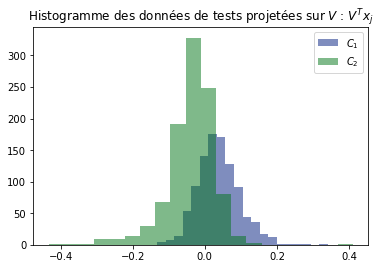

[[80, 200], [400, 20], [80, 200]]
n :  980
lenMM : 3
MM_gathered : 
  0.905682    -1.53159    0.0618304    -0.0484037     1.11948      -1.212  
  -1.53159    0.824589   -0.0665062     0.0954148    -1.31798     1.08809  
 0.0618304  -0.0665062    0.0047108   -0.00623109   0.0698015  -0.0579252  
-0.0484037   0.0954148  -0.00623109  -0.000383289  -0.0800253   0.0727445  
   1.11948    -1.31798    0.0698015    -0.0800253     1.64442     -1.5018  
    -1.212     1.08809   -0.0579252     0.0727445     -1.5018    0.978784  


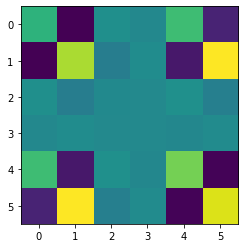

 0.0108424  
 -0.214981  
 0.0147362  
0.00189585  
  0.102996  
 -0.113315  
0.0816327         0         0          0          0         0  
        0  0.204082         0          0          0         0  
        0         0  0.408163          0          0         0  
        0         0         0  0.0204082          0         0  
        0         0         0          0  0.0816327         0  
        0         0         0          0          0  0.204082  


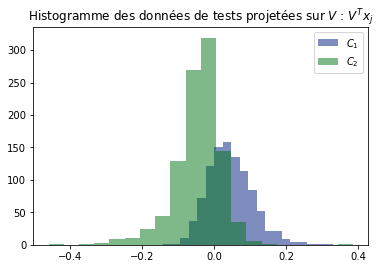

[[80, 200], [400, 20], [80, 200], [400, 20]]
n :  1400
lenMM : 4
MM_gathered : 
  0.905682    -1.53159    0.0618304    -0.0484037     1.11948      -1.212    1.22374    -1.57061  
  -1.53159    0.824589   -0.0665062     0.0954148    -1.31798     1.08809   -1.13246     1.61769  
 0.0618304  -0.0665062    0.0047108   -0.00623109   0.0698015  -0.0579252  0.0911456  -0.0798997  
-0.0484037   0.0954148  -0.00623109  -0.000383289  -0.0800253   0.0727445  -0.115647   0.0682284  
   1.11948    -1.31798    0.0698015    -0.0800253     1.64442     -1.5018    1.14971    -0.95644  
    -1.212     1.08809   -0.0579252     0.0727445     -1.5018    0.978784    -1.1718     1.70674  
   1.22374    -1.13246    0.0911456     -0.115647     1.14971     -1.1718    1.64806    -1.71215  
  -1.57061     1.61769   -0.0798997     0.0682284    -0.95644     1.70674   -1.71215     1.02319  


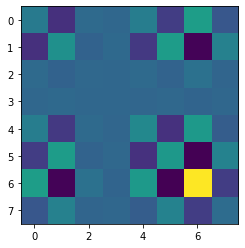

-0.0759282  
 -0.208353  
0.00983928  
 0.0171903  
 0.0848807  
-0.0585466  
   0.21716  
 0.0618006  
0.0571429         0         0          0          0         0         0          0  
        0  0.142857         0          0          0         0         0          0  
        0         0  0.285714          0          0         0         0          0  
        0         0         0  0.0142857          0         0         0          0  
        0         0         0          0  0.0571429         0         0          0  
        0         0         0          0          0  0.142857         0          0  
        0         0         0          0          0         0  0.285714          0  
        0         0         0          0          0         0         0  0.0142857  


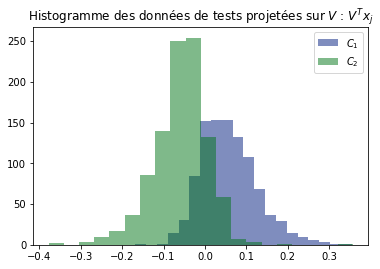

In [209]:
from scipy.stats import zscore
from scipy.io import loadmat

dataset = "amazon"
%matplotlib inline
m=2
p=400
n11, n12, n21, n22 = 100, 100, 50, 50
var, emp_rate = [], []
if dataset == "amazon":
    k = 3
    mat = loadmat("books_400.mat")
    mat_test = loadmat("kitchen_400.mat")

    X_test_aggregated, y_test = mat_test['fts'], mat_test['labels']
    X_test_aggregated = preprocess(X_test_aggregated,p)
    X_test, n_t_test = divide_array(X_test_aggregated, y_test, 1)
    
    X_test = normalisation(X_test, p)
    # X1 contient toute la premiere tâche
    X1_aggregated, y = mat["fts"], mat["labels"]
    X1_aggregated = preprocess(X1_aggregated, p)
#     X1_aggregated = zscore(X1_aggregated, axis=None)
    
    X, n_t = divide_array(X1_aggregated, y, 1)
    X = [[X[0][0].T[:n11].T, X[0][1].T[:n12].T]]
    n_t = [[n11, n12]]
#     X = normalisation(X, p, True)
    X.append([X_test[:][0][0].T[:n21].T, X_test[:][0][1].T[:n22].T])
#     X_test = [[X_test[0][0].T[n21:n21+500].T, X_test[0][1].T[n22:n22+50].T]]
    print(X_test[0][0].shape, X_test[0][1].shape)
    print(n_t_test)
#     n_t_test = [[500, 500]]
    n_t.append([n21, n22])
    task_target = 1
    
for t in range(2, k+2):
#     nt = sum(n_t_test[0])
    # add tasks
    if t>2:
        if t==3:
            mat = loadmat("dvd_400.mat")
            X2_aggregated, y2 = mat["fts"], mat["labels"] 
#             X2_aggregated = zscore(X2_aggregated, axis=None)
            X2_aggregated = preprocess(X2_aggregated, p)
            X_tmp, n_t_tmp = divide_array(X2_aggregated, y2, 1)
            X_tmp = [[X_tmp[0][0].T[:n11].T, X_tmp[0][1].T[:n12].T]]
#             X_tmp = normalisation(X_tmp, p)
#             X_tmp = normalisation(X_tmp, p, True)
            X.append(X_tmp[0][:])
            n_t.append([n11, n12])
        elif t==4:
            mat = loadmat("elec_400.mat")
            X3_aggregated, y3 = mat["fts"], mat["labels"] 
#             X3_aggregated = zscore(X3_aggregated, axis=None)
            X3_aggregated = preprocess(X3_aggregated, p)
            X_tmp, n_t_tmp = divide_array(X3_aggregated, y3, 1)
            X_tmp = [[X_tmp[0][0].T[:n21].T, X_tmp[0][1].T[:n22].T]]
#             X_tmp = normalisation(X_tmp[:], p, True)
#             X_tmp = normalisation(X_tmp, p)
            X.append(X_tmp[0][:])
            n_t.append([n21, n22])
    print(n_t)
    n = sum(list(map(sum, (n_t[i] for i in range(t)))))
    print("n : ", n)
    MM = []
    diag = []
    for i in range(t):
        MM1, diag1 = empirical_mean_old(1, m, [X[i]], p, [n_t[i]])
        # chaque moyenne empirique calculée est un vecteur de taille p
#         sent+=1
#         t_MM.append(time()-t0)
        MM.append(MM1)
        diag.append(diag1)
    print(f"lenMM : {len(MM)}")
    # CENTRAL SERVER
#     t0 = time()
    # sending empirical means to central server
    V, y_opt, correlation_matrix, Dc, c0 = merging_center(MM, diag, t, m, p, n, n_t, task_target, True)
    matprint(Dc)
    # END CENTRAL SERVER
    VTX = V.T@X_test_aggregated.T
    debug_histogram(V, X_test_aggregated.T, n_t_test)
    var.append(np.var(VTX))
    m_t = create_mt(t, m, y_opt, Dc, correlation_matrix)
    
#     erreur_theorique = error_rate(t, m,  Dc, MM_true, c0)[0][0]
    emp_rate.append(compute_error_rate(X_test, V, m_t, 1, m, n_t_test, Dc, c0))
    
%matplotlib qt
plt.plot(list(range(k)), emp_rate, '-o')
lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.fill_between(list(range(k)), lower, upper, alpha=0.2, label="variance")
ticks = ["Books", "DVDs", "Electronics"]
plt.xticks(range(len(ticks)), ticks, size='larger')
plt.xlabel("Added tasks")
# plt.ylim(0.18,0.24)
plt.ylabel("Empirical error rate")
plt.legend()
plt.grid()
plt.title("Real data")
plt.show()

# MNIST


In [100]:
pca = PCA(0.99).fit(X1)
pca.n_components_

176

100 composantes sont suffisantes


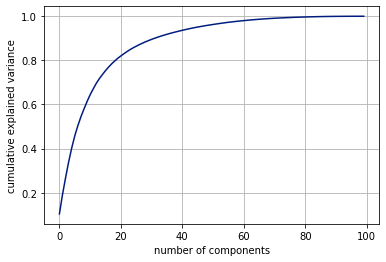

In [72]:
from sklearn.decomposition import PCA

pca = PCA().fit(X1)
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

print("100 composantes sont suffisantes")

In [183]:
from keras.datasets import mnist
from sklearn.decomposition import PCA
p=100
def mnist_prepocessing(p):
    (X_train,y_train), (X_t,y_test)=mnist.load_data()
    print(X_t.shape, X_train.shape)
    X_train, X_t = np.reshape(X_train, (60000, 784)), np.reshape(X_t, (10000, 784))
    X_train, X_t = PCA(n_components=100).fit(X_train).transform(X_train), PCA(n_components=100).fit(X_t).transform(X_t)
    X_train, X_t = X_train.T, X_t.T
    print(X_t.shape, X_train.shape)
    sigma=1
#     X_train = X_train+sigma*np.random.randn(X_train.shape[0], X_train.shape[1])
#     X_t = X_t+sigma*np.random.randn(X_t.shape[0], X_t.shape[1])
    
    
    X_train /= np.max(X_train)
    X_t /= np.max(X_t)
    # mean_data=mean(data,2);mean_test=mean(test,2);
    # norm2_data=0;norm2_test=0;
    # for i=1:init_n
    #     norm2_data=norm2_data+1/init_n*norm(data(:,i)-mean_data)^2;
    # end
    # for i=1:test_n
    #     norm2_test=norm2_test+1/test_n*norm(test(:,i)-mean_test)^2;
    # end
    #  data=(data-mean_data*ones(1,size(data,2)))/sqrt(norm2_data)*sqrt(p);
    #  test=(test-mean_test*ones(1,size(test,2)))/sqrt(norm2_test)*sqrt(p);
    mean_data = np.mean(X_train,axis=1); mean_test=np.mean(X_t, axis=1)
    mean_data = np.reshape(mean_data, (p,1)); mean_test = np.reshape(mean_test, (p,1))
    norm2_data=0;norm2_test=0;
    for i in range(len(X_train)):
        norm2_data += 1/len(X_train)*np.linalg.norm(X_train.T[i]-mean_data)**2
    for i in range(len(X_t)):
        norm2_test += 1/len(X_t)*np.linalg.norm(X_t.T[i]-mean_test)**2
    X_train = (X_train-mean_data@np.ones((1, X_train.shape[1])))/np.sqrt(norm2_data)*np.sqrt(p)
    X_t = (X_t-mean_test@np.ones((1, X_t.shape[1])))/np.sqrt(norm2_test)*np.sqrt(p)
    
    return X_train, X_t
    

In [184]:
X_train, X_t = mnist_prepocessing(p)
print(np.linalg.norm(X_t))

(10000, 28, 28) (60000, 28, 28)
(100, 10000) (100, 60000)
102.18950775573038


In [185]:
X0 = (X_train.T[y_train==0].T)
X1 = (X_train.T[y_train==1].T)
X2 = (X_train.T[y_train==2].T)
X3 = (X_train.T[y_train==3].T)
X4 = (X_train.T[y_train==4].T)
X5 = (X_train.T[y_train==5].T)
X6 = (X_train.T[y_train==6].T)
X7 = (X_train.T[y_train==7].T)
X8 = (X_train.T[y_train==8].T)
X9 = (X_train.T[y_train==9].T)

X0_test = (X_t.T[y_test==0].T)
X1_test = (X_t.T[y_test==1].T)
X2_test = (X_t.T[y_test==2].T)
X3_test = (X_t.T[y_test==3].T)
X4_test = (X_t.T[y_test==4].T)
X5_test = (X_t.T[y_test==5].T)
X6_test = (X_t.T[y_test==6].T)
X7_test = (X_t.T[y_test==7].T)
X8_test = (X_t.T[y_test==8].T)
X9_test = (X_t.T[y_test==9].T)

n :  200
MM_gathered : 
   0.252047    0.122466  -0.00811616  0.0600103  
   0.122466    0.165635   -0.0200639  0.0936121  
-0.00811616  -0.0200639     0.336848  -0.064017  
  0.0600103   0.0936121    -0.064017    0.22749  


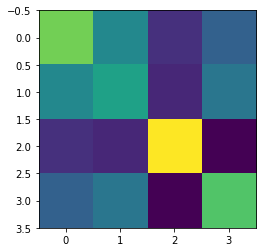

-0.0957943  
  -0.17697  
  0.670774  
 -0.494176  


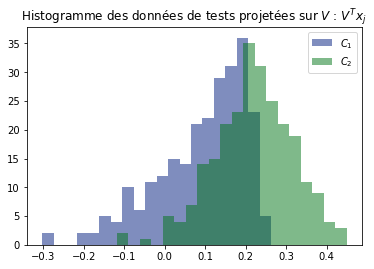

n :  400
MM_gathered : 
   0.252047    0.122466  -0.00811616   0.0600103   -0.0679379  -0.0623269  
   0.122466    0.165635   -0.0200639   0.0936121   -0.0375744  -0.0145974  
-0.00811616  -0.0200639     0.336848   -0.064017  -0.00918252   0.0553276  
  0.0600103   0.0936121    -0.064017     0.22749   -0.0837473  -0.0509044  
 -0.0679379  -0.0375744  -0.00918252  -0.0837473     0.207509   0.0368603  
 -0.0623269  -0.0145974    0.0553276  -0.0509044    0.0368603    0.178382  


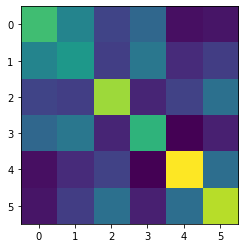

-0.164368  
-0.345842  
  1.33001  
-0.961217  
 0.199691  
 0.295883  


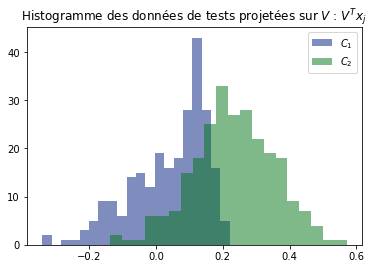

n :  500
MM_gathered : 
   0.252047    0.122466  -0.00811616   0.0600103   -0.0679379  -0.0623269  -0.0283291  -0.0784693  
   0.122466    0.165635   -0.0200639   0.0936121   -0.0375744  -0.0145974  -0.0230806  -0.0380218  
-0.00811616  -0.0200639     0.336848   -0.064017  -0.00918252   0.0553276    0.016168  -0.0618442  
  0.0600103   0.0936121    -0.064017     0.22749   -0.0837473  -0.0509044  -0.0374184    0.034162  
 -0.0679379  -0.0375744  -0.00918252  -0.0837473     0.207509   0.0368603   0.0488513   -0.109455  
 -0.0623269  -0.0145974    0.0553276  -0.0509044    0.0368603    0.178382  0.00801014  -0.0496836  
 -0.0283291  -0.0230806     0.016168  -0.0374184    0.0488513  0.00801014   0.0962709  -0.0236511  
 -0.0784693  -0.0380218   -0.0618442    0.034162    -0.109455  -0.0496836  -0.0236511    0.330771  


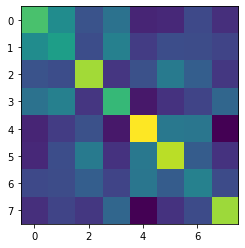

-0.215835  
-0.436462  
  1.65283  
 -1.19477  
 0.230923  
 0.362975  
 0.196618  
-0.325768  


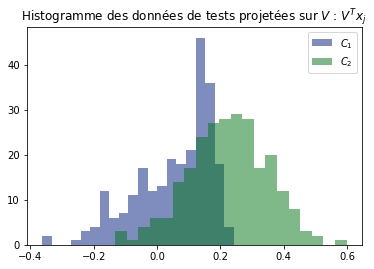

n :  700
MM_gathered : 
   0.252047    0.122466  -0.00811616   0.0600103   -0.0679379  -0.0623269  -0.0283291  -0.0784693   -0.0914216    0.107221  
   0.122466    0.165635   -0.0200639   0.0936121   -0.0375744  -0.0145974  -0.0230806  -0.0380218   -0.0986529    0.163256  
-0.00811616  -0.0200639     0.336848   -0.064017  -0.00918252   0.0553276    0.016168  -0.0618442  -0.00348294  -0.0300047  
  0.0600103   0.0936121    -0.064017     0.22749   -0.0837473  -0.0509044  -0.0374184    0.034162   -0.0103408   0.0952362  
 -0.0679379  -0.0375744  -0.00918252  -0.0837473     0.207509   0.0368603   0.0488513   -0.109455   0.00728737  -0.0519195  
 -0.0623269  -0.0145974    0.0553276  -0.0509044    0.0368603    0.178382  0.00801014  -0.0496836    0.0224261  -0.0104999  
 -0.0283291  -0.0230806     0.016168  -0.0374184    0.0488513  0.00801014   0.0962709  -0.0236511   -0.0293597  -0.0270816  
 -0.0784693  -0.0380218   -0.0618442    0.034162    -0.109455  -0.0496836  -0.0236511    0.330771    

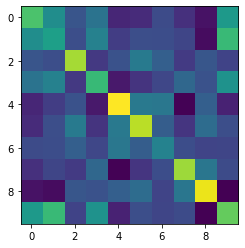

 -0.254798  
 -0.528564  
   2.30012  
  -1.62808  
  0.301438  
     0.507  
   0.26203  
 -0.465119  
-0.0339623  
 -0.606133  


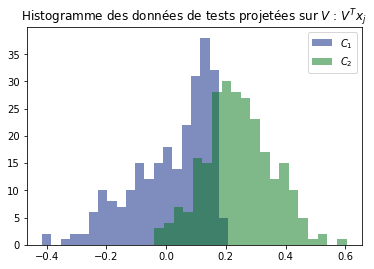

n :  800
MM_gathered : 
   0.252047    0.122466  -0.00811616   0.0600103   -0.0679379  -0.0623269  -0.0283291  -0.0784693   -0.0914216    0.107221  -0.0730239  -0.0283291  
   0.122466    0.165635   -0.0200639   0.0936121   -0.0375744  -0.0145974  -0.0230806  -0.0380218   -0.0986529    0.163256  -0.0396562  -0.0230806  
-0.00811616  -0.0200639     0.336848   -0.064017  -0.00918252   0.0553276    0.016168  -0.0618442  -0.00348294  -0.0300047  -0.0224697    0.016168  
  0.0600103   0.0936121    -0.064017     0.22749   -0.0837473  -0.0509044  -0.0374184    0.034162   -0.0103408   0.0952362  -0.0967498  -0.0374184  
 -0.0679379  -0.0375744  -0.00918252  -0.0837473     0.207509   0.0368603   0.0488513   -0.109455   0.00728737  -0.0519195    0.253666   0.0488513  
 -0.0623269  -0.0145974    0.0553276  -0.0509044    0.0368603    0.178382  0.00801014  -0.0496836    0.0224261  -0.0104999   0.0395074  0.00801014  
 -0.0283291  -0.0230806     0.016168  -0.0374184    0.0488513  0.00801014   0.0962

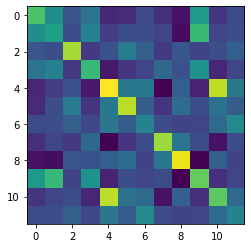

 -0.281361  
 -0.598948  
   2.63064  
  -1.84773  
  0.310857  
  0.575628  
  0.281116  
 -0.515805  
-0.0359821  
 -0.684929  
  0.288365  
  0.281116  


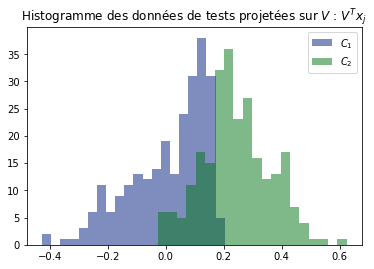

No handles with labels found to put in legend.


In [191]:
%matplotlib inline
n1, n2 = 100, 50
X_test = [[X1_test.T[:250].T, X4_test.T[:250].T]]
n_t_test = [[250, 250]]
X = [[X7.T[:n2].T, X9.T[:n2].T]]
n_t = [[n2,n2]]
m, k = 2, 5
var, emp_rate = [], []
task_target = 1

# X_test = normalisation(X_test, p, True)
n = sum(list(map(sum, (n_t[i] for i in range(len(n_t))))))
X_test_aggregated = aggregate_array(X_test, p, n, 1, 2)

# X = normalisation(X, p, True)

for t in range(2, k+2):
#     nt = sum(n_t_test[0])
    
    # add tasks
    if t==2:
        X_tmp = [[X1.T[:n2].T, X4.T[:n2].T]]
#         X_tmp = normalisation(X_tmp,p,True)
        X.append(X_tmp[:][0])
        n_t.append([n2, n2])
    elif t==3:
        X_tmp = [[X3.T[:n1].T, X8.T[:n1].T]]
        X.append(X_tmp[:][0])
        n_t.append([n1, n1])
    elif t==4:
        X_tmp = [[X5.T[:n2].T, X6.T[:n2].T]]
        X.append(X_tmp[:][0])
        n_t.append([n2, n2])
    elif t==5:
        X_tmp = [[X2.T[:n1].T, X9.T[:n1].T]]
        X.append(X_tmp[:][0])
        n_t.append([n1, n1])
    elif t==6:
        X_tmp = [[X3.T[:n2].T, X5.T[:n2].T]]
        X.append(X_tmp[:][0])
        X.append([X3.T[:n2].T, X5.T[:n2].T])
        n_t.append([n2, n2])
    
    n = sum(list(map(sum, (n_t[i] for i in range(len(n_t))))))
    print("n : ", n)
            
    MM = []
    diag = []
    for i in range(t):
        MM1, diag1 = empirical_mean_old(1, m, [X[i]], p, [n_t[i]])
        MM.append(MM1)
        diag.append(diag1)

    V, y_opt, correlation_matrix, Dc, c0 = merging_center(MM, diag, t, m, p, n, n_t, task_target, True)
    
    VTX = V.T@X_test_aggregated
    debug_histogram(V, X_test_aggregated, n_t_test)
    var.append(np.var(VTX))
    m_t = create_mt(t, m, y_opt, Dc, correlation_matrix)
    emp_rate.append(compute_error_rate(X_test, V, m_t, 1, m, n_t_test, Dc, c0))

%matplotlib qt
plt.plot(list(range(k)), emp_rate, '-o')
# lower = np.array(emp_rate) - np.array(var)
# upper = np.array(emp_rate) + np.array(var)
# plt.fill_between(list(range(k)), lower, upper, alpha=0.2, label="variance")
plt.legend()
ticks = ["(7-9)", "(3-8)", "(5-6)", "(2-9)", "(3-5)"]
plt.xticks(range(len(ticks)), ticks, size='larger')
plt.xlabel("Added tasks")
plt.ylabel("Empirical error rate")
plt.grid()
plt.title("MNIST data")
plt.show()

In [178]:
print(X0.shape)

(100, 5923)


# Optimalité

In [192]:
# print((MM-MM*(np.identity(2*t)+1/sigma**2*np.identity(2*t)*MM)).shape)
from scipy.stats import norm
def bayes_risk(rho, gamma):
    """
    Compute minimal Bayes error rate of label estimation for task t
    """
    if rho == 1/2:
        return 1-norm.cdf(np.sqrt(gamma))

    return 1-rho*norm.cdf(np.sqrt(gamma)-1/(2*np.sqrt(gamma))*np.log((1-rho)/rho))-(1-rho)*norm.cdf(np.sqrt(gamma)+1/(2*np.sqrt(gamma))*np.log((1-rho)/rho))

task 1 empirical mean = 0.01
   1.05412   -0.969539    0.118643  -0.0498272  
 -0.969539     1.09495  -0.0732167   0.0143571  
  0.118643  -0.0732167     1.10769   -0.898358  
-0.0498272   0.0143571   -0.898358     1.04712  
10   0  0  0  
 0  10  0  0  
 0   0  5  0  
 0   0  0  5  
[0.9382795570891507, 0.8791901119121424]
task 1 empirical mean = 0.012761423749153965
  1.05412  -0.969539   0.442593  -0.373777  
-0.969539    1.09495  -0.406935   0.348076  
 0.442593  -0.406935    1.17447  -0.950863  
-0.373777   0.348076  -0.950863    1.08535  
10   0  0  0  
 0  10  0  0  
 0   0  5  0  
 0   0  0  5  
[1.0035690335885885, 0.9164697992833846]
task 1 empirical mean = 0.014120226591665966
  1.05412  -0.969539    0.76426  -0.695444  
-0.969539    1.09495  -0.745352   0.686492  
  0.76426  -0.745352    1.25329   -1.01911  
-0.695444   0.686492   -1.01911    1.14301  
10   0  0  0  
 0  10  0  0  
 0   0  5  0  
 0   0  0  5  
[1.080817316912103, 0.9727939749359849]
task 1 empirical mean =

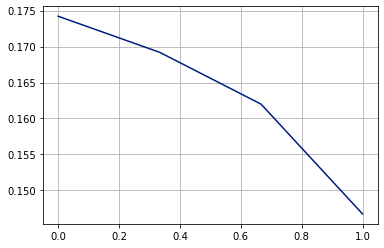

In [82]:
# T = 2, p_t = 1, lambda = 1, a1, a2 = 1 ?
# calcul de q_t
p = 100
m = 2
t = 2
beta = np.linspace(0,1,4)
n_t = [[1000, 1000], [500, 500]]
n = sum(list(map(sum, (n_t[i] for i in range(t)))))
n_t_test = [[1000, 1000]]
nt = sum(n_t_test[0])
random_state=100
sigma = 1
R1, R2 = [], []
for b in beta:
    qt = []
    M = mean_matrix(p, b, t, random_seed=random_state)
#     M = [[]]
    print(f"task 1 empirical mean = {np.mean(M[1][0])}")
#     M1 = np.mean(np.concatenate((M[0][0], M[0][1]), axis=1), axis=1)
#     M2 = np.mean(np.concatenate((M[1][0], M[1][1]), axis=1), axis=1)
    X, y_bs = gaussian_synthetic_data(n, p, m, t, n_t, M, random_state)
#     if b==0:
#         M_prec=M[:]
#         X_prec=X[:]
#     else:
#         print(f"Test : {X_prec[1][0]==X[1][0]}")
#         print(f"Test : {M_prec[1][0]==M[1][0]}")
#     X = normalisation(X, p)
#     print(X[1][0].T[10].T)
#     X_test, y_test = gaussian_synthetic_data(nt, p, m, 1, n_t_test, [M[1]], random_state)
    # M1 et M2 sont les moyennes empiriques pour les taches 1 et 2
#     M1_true = true_mean(M,p,2,2)
#     M1 = empirical_mean_old(1, 1, [[np.concatenate((X[0][0],X[0][1]), axis=1)]], p, [[sum(n_t[0])]])[0]
#     M2 = empirical_mean_old(1, 1, [[np.concatenate((X[1][0],X[1][1]), axis=1)]], p, [[sum(n_t[1])]])[0]
#     if b==0:
#         M2_prec=M2[:]
#     else:
#         print(f"Test : {M2_prec==M2}")
#         print(M1.T@M2)
#         print(M1.T@M2_prec)
#         print(f"Encore un test : {M1.T@M2==M1.T@M2_prec}")
#     print(f"task 1 empirical mean = {np.mean(M1)}")
#     print(f"task 2 empirical mean = {np.mean(M2)}")
#     print(M1, M2)
#     MM = np.array([[(M1.T@M1)[0][0], (M1.T@M2)[0][0]],[(M2.T@M1)[0][0], (M2.T@M2)[0][0]]])
    M1 = empirical_mean_old(2,2,X,p,n_t)[0]
    MM = M1.T@M1
    matprint(MM)
    r1, r2 = bayes_optimal(n_t, MM, p)
    R1.append(r1)
    R2.append(r2)
    
plt.plot(beta, R2)
plt.grid()
plt.show()
    

In [193]:
def bayes_optimal(n_t, MM, p, sigma=1):
    """
    Renvoie R1, R2
    """
    qt = []
    a1, a2, a3, a4 = n_t[0][0]/p, n_t[0][1]/p, n_t[1][0]/p, n_t[1][1]/p
    D = np.diag([a1/sigma**2, a2/sigma**2, a3/sigma**2, a3/sigma**2])
    matprint(D)
    Q = np.diag((MM-MM*np.linalg.inv(np.identity(4)+D*MM)))
    qt.append(Q[2])
    qt.append(Q[3])
    
    print(qt)
    if bayes_risk(n_t[0][0]/sum(n_t[0]), qt[0])>0.5:
        R1 = (1-bayes_risk(n_t[0][0]/sum(n_t[0]), qt[0]))
    else:
        R1 = (bayes_risk(n_t[0][0]/sum(n_t[0]), qt[0]))
    if bayes_risk(n_t[1][0]/sum(n_t[1]), qt[1])>0.5:
        R2 = (1-bayes_risk(n_t[1][0]/sum(n_t[1]), qt[1]))
    else:
        R2 = (bayes_risk(n_t[1][0]/sum(n_t[1]), qt[1]))  
    return R1, R2

In [194]:
print(R1)
plt.plot(beta, R1, '-o', label="R1")
plt.plot(beta, R2, '-o', label="R2")
plt.legend()
plt.grid()
plt.show()

[]


ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

# Algorithme distribué k-tâches m classes
On se ramène à un cas 2-tâches 2-classes en fait

In [81]:
from scipy.stats import zscore

def z_normalize(X, k):
    """
    Normalise les données.
    k tâches, m classes
    X le tableau de données.
    """
    return zscore(X)

In [195]:
# Algorithme 1 du papier
k = 2
m = 10
n1 = [100 for i in range(m)]
n2 = [50 for i in range(m)]
p = 100
n_t = [n1, n2]
n_t_test = [[1000 for i in range(m)]]
nt = sum(n_t_test[0])
# faire quelque chose de généralisable
n = sum(list(map(sum, (n_t[i] for i in range(k)))))
c0 = p/n
var = []
emp_rate = []
scores = []
random_state=100
# si je peux essayer de faire plus dégeu pour le n 
M = mean_matrix(p, k=k, m=m, random_seed=random_state, random=True)
X, y_bs = gaussian_synthetic_data(n, p, m, k, n_t, M, random_state)

# choisir la tache que l'on veut tester
test_task = 1
X_test, y_test = gaussian_synthetic_data(n, p, m, 1, n_t_test, [M[test_task]], random_state)
X, X_test = z_normalize(X, k, m), z_normalize(X_test, 1, m)
# beta = []
# [[[],[]], [[], []]]

# inverser les boucles ?
for l in range(m):
    for t in range(k):
        if t==test_task:
            # how does it benefit from the other tasks?
            # pourquoi faire une boucle sur les tâches ?
    #         beta.append(l*k+t)
            X_data = []
            # on ajoute la premiere classe de la premiere tache
            X_data.append([X[t][l]])
            current_n_t = [[n_t[t][l]]]
            s = 0           

            tmp = np.empty((p, 0), float)
    #         print("tmp : ", tmp)
            for cl in range(m):
                if cl==l:
                    continue
    #             print("on ajoute : ", X[t][cl])
    #             print(X[t][cl].shape)
                tmp = np.concatenate((tmp, X[t][cl]), axis=1)
                s += n_t[t][cl]
    #         print("tmp : ", tmp)
            X_data[0].append(tmp)
    #         qui est la deuxieme tâche ? 
    #         X_data.append(X_test[0])
#             regrouper toutes les autres tâches
#             a reprendre
            temp = []
            tmp1 = np.empty((p, 0), float)
            s1 = 0
            sc = []
            for tp in range(k):
                if tp == test_task:
                    continue
                for l in range(m):
                    tmp1 = np.concatenate((tmp1, X[tp][l]), axis=1)
                    s1 += n_t[tp][l]
                temp.append(tmp1)
                sc.append(s2)
                sc.append(s1)
            X_data.append(temp)
    #         print("len(X) : ", len(X_data))
    #         print("len(X[0]) : ", len(X_data[1][0]))
            current_n_t[0].append(s)
            current_n_t.append(sc)
            print(f"current nt = {current_n_t}")
            MM = empirical_mean(2, 2, X_data, p, current_n_t)
            matprint(MM)
            c = estimate_c(current_n_t, n, 2, 2)
            Dc = np.diag(c)
            matprint(Dc)
            correlation_matrix = compute_M_cal(n, p, Dc, MM, 2, True)

            y = label_evaluation(2, 2, Dc, MM, c0)
            matprint(y)
            X_aggregated = aggregate_array(X_data, p, n, 2, 2)
            X_test_aggregated = aggregate_array(X_test, p, nt, 1, 2)

            # no need to compute V anymore
            J = create_J(2, 2, n, current_n_t)
            V = compute_V(y, X_aggregated, J, n)
            # On time le temps d'inférence

        #     debug_histogram(V_true, X_test_aggregated, n_t_test)
        #     print("V = ")
            VTX = V.T@X_test_aggregated
            var.append(np.var(VTX))
            debug_histogram(V, X_test_aggregated, n_t_test)

            # pour l'instant pas vraiment utilisé
            m_t = create_mt(2, 2, y, Dc, correlation_matrix)
            # gxt in R^1xn

            gxt = y.T@J.T@X_aggregated.T@X_test_aggregated/np.linalg.norm(y.T@J.T@X_aggregated.T)
            gxt = np.reshape(gxt, (nt))
            scores.append(gxt-m_t[0][0])

            erreur_empirique = compute_error_rate(X_test, V, m_t, 1, 2, n_t_test, Dc, c0)
    #         erreur_theorique = error_rate(t, m,  Dc, MM_true, c0)[0][0]
            emp_rate.append(erreur_empirique)
    #         th_rate.append(erreur_theorique)
    #         relative_error_rate.append(abs(erreur_empirique - erreur_theorique)/erreur_theorique)

estimated_class=[]
for j in range(len(scores[0])):
#     print(np.argmax(scores[l][j] for l in range(m)))
    classes=[]
    for l in range(m):
#         print(scores[l][j])
        classes.append(scores[l][j])
#     print(classes)
    estimated_class.append(np.argmax(classes))

        
        
# lower = np.array(emp_rate) - np.array(var)
# upper = np.array(emp_rate) + np.array(var)
# plt.plot(beta, emp_rate, '-o', label='empirical rate')
# plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
# plt.legend()
# plt.title(f"2-class Gaussian mixture transfer error rate for n={n} and p={p}")
# plt.xlabel("Task relatedness (beta)")
# plt.ylabel("error rate")
# plt.grid()
# plt.show()
        

random
beta 0.5434049417909654


KeyboardInterrupt: 

In [162]:
print(X_data[1][1].shape)

(100, 1000)


In [168]:
estimated_class = []
erreur= []

for j in range(len(scores[0])):
#     print(np.argmax(scores[l][j] for l in range(m)))
    classes=[]
    for l in range(m):
#         print(scores[l][j])
        classes.append(scores[l][j])
#     print(classes)
    estimated_class.append(np.argmax(classes))
    erreur.append(int(np.argmax(classes)==y_test[j]))
    
err = erreur.count(1)/len(scores[0])
if err>0.5:
    err = 1-err

print(err)
# estimated_class
# print(np.argmax(scores[l][0] for l in range(m)))
# print(np.argmax((scores[0][0], scores[1][0])))

0.5
800


In [165]:
ones=0
twos=0
for i in range(len(scores[0])):
    maxi = scores[0][i]
    indice = 0
    for idx, score in enumerate(scores):
        if score[i] > maxi:
            maxi = score[i]
            indice = idx
    l = indice%2+1
    if l == 1:
        ones+=1
    else:
        twos+=1
    
#     print(l)
print(f"Empirical proportions : \nC1 proportion : {ones/len(scores[0])*100} %, C2 proportion : {twos/len(scores[0])*100} %")
print(f"Theoritical proportions : \nC1 proportion : {round(sum(n1)/(sum(n1)+sum(n2))*100, 3)} %, C2 proportion : {round(sum(n2)/(sum(n1)+sum(n2))*100, 3)} %")

Empirical proportions : 
C1 proportion : 0.0 %, C2 proportion : 100.0 %
Theoritical proportions : 
C1 proportion : 66.667 %, C2 proportion : 33.333 %


In [98]:
print(current_n_t)
print(gxt.shape)
print(J.T.shape)
print(X_aggregated.T.shape)
print(X_test_aggregated.shape)

[[200, 600]]
(1, 800)
(2, 800)
(800, 100)
(100, 800)


In [102]:
print(tmp.shape)
print(s)
print(len(X_data))
print(np.ones((n_t[0][0], 1)).T.shape)
print((X_data[0][0].T.shape))
print((X_data[0][1].shape))
print(np.ones(n_t[0][1]).shape)
#1x240x50
print(X_data)
print(X[3][1])
print(X[3][0])

(2, 2)
2
2
(1, 4)
(2, 2)
(2, 2)
(4,)
[[array([[-0.88007943, -0.47482649],
       [-0.96586158,  0.2590587 ]]), array([[0.92226127, 0.38656715],
       [0.91331841, 0.40724621]])], [array([[0.36683514, 0.43040179, 0.0591088 , 0.82261317],
       [0.24975802, 0.77567657, 0.21940746, 0.53647661]]), array([[-0.34926064, -0.34675433, -0.05486188, -0.8687742 ],
       [-0.1093427 , -0.39596414, -0.807452  , -0.42341213]])]]
[[-0.88007943 -0.47482649]
 [-0.96586158  0.2590587 ]]
[[0.92226127 0.38656715]
 [0.91331841 0.40724621]]


In [65]:
print(n_t[0][0])
print(X[1][0].shape)
print(X_data[0][0].shape)
print(current_n_t)

50
(200, 10)
(200, 50)
[[50, 50], [500, 500]]


In [104]:
n_t = [[10,10], [4,4], [5,5]]
n = sum(list(map(sum, (n_t[i] for i in range(2)))))
print(list(n_t[i] for i in range(3) if i!=0))
current = [n_t[0], list(n_t[i] for i in range(2) if i!=0)[0]]
current

[[4, 4], [5, 5]]


[[10, 10], [[4, 4]]]

In [1]:
import pandas

In [6]:
help(pandas.DataFrame.sum)

Help on function sum in module pandas.core.generic:

sum(self, axis=None, skipna=None, level=None, numeric_only=None, min_count=0, **kwargs)
    Return the sum of the values over the requested axis.
    
    This is equivalent to the method ``numpy.sum``.
    
    Parameters
    ----------
    axis : {index (0), columns (1)}
        Axis for the function to be applied on.
    skipna : bool, default True
        Exclude NA/null values when computing the result.
    level : int or level name, default None
        If the axis is a MultiIndex (hierarchical), count along a
        particular level, collapsing into a Series.
    numeric_only : bool, default None
        Include only float, int, boolean columns. If None, will attempt to use
        everything, then use only numeric data. Not implemented for Series.
    min_count : int, default 0
        The required number of valid values to perform the operation. If fewer than
        ``min_count`` non-NA values are present the result will b